In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt

## Importing data

In [2]:
sc.settings.verbosity = 3

df = pd.read_csv("../7_ovary.tsv",sep="\t",header=None)
df.set_index(df.columns[0],inplace=True)

adata = sc.AnnData(df.T)
adata

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 7549 × 11944

## Data first approach

We already have the tag for the number of genes per count, and the total counts. We will tag Ribosomal and Mitochondrial expression to assess the quality controle (QC).

In [3]:
adata.var['mt'] = adata.var_names.str.startswith('mt:') 
adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=[20], log1p=True, inplace=True)

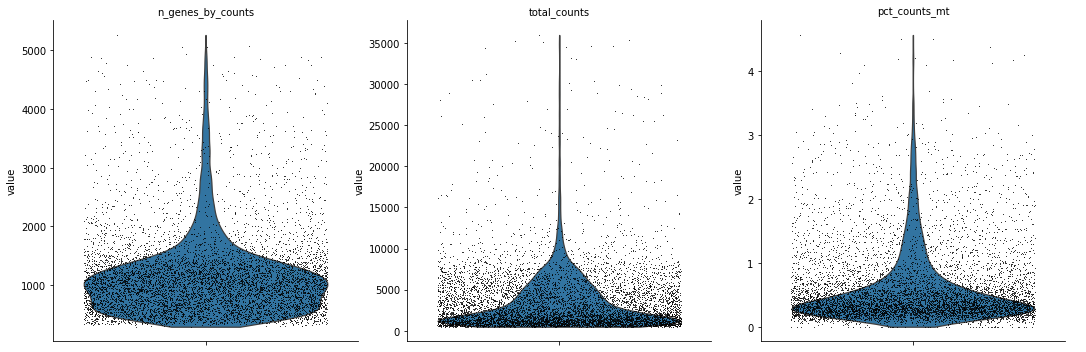

In [4]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)

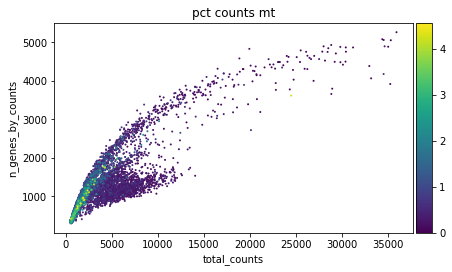

In [5]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Cell Filtering and Gene Filtering

We filter the cells with little expression as they can indicated low quality cells (degraded RNA). Same goes for the genes with very small amount of expression. <br> We also tag highly variable genes.

filtered out 726 genes that are detected in less than 3 cells


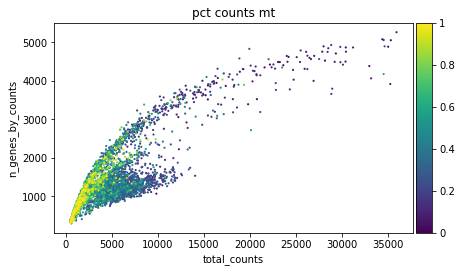

In [6]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs["pct_counts_mt"] <= 1, :]

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Normalization

Data is normalised and log-reduced in order to remove sequencing depth bias and gene length bias.

/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


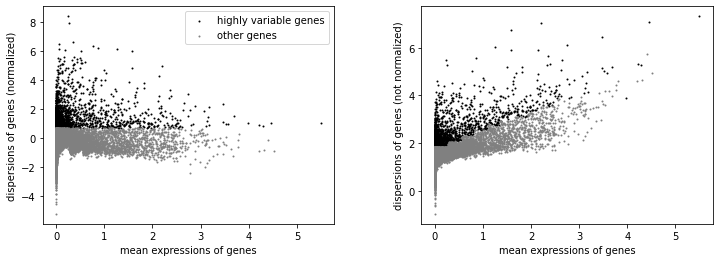

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)


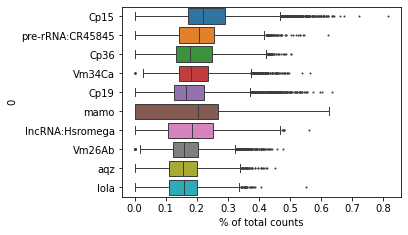

In [8]:
sc.pl.highest_expr_genes(adata, n_top=10)

We freeze the normalized and log-reduced adata by updating its raw attribute to perform further analysis.

In [9]:
adata.raw = adata

## Dimension Reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


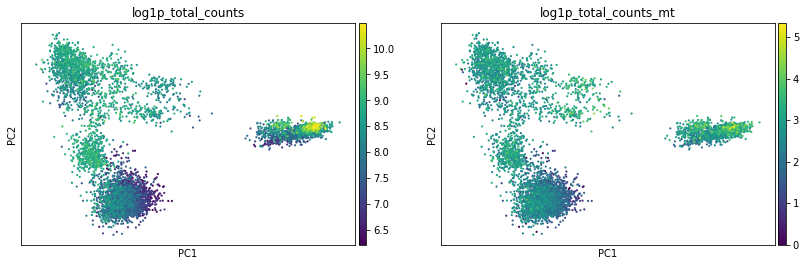

In [10]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca(adata,color=['log1p_total_counts','log1p_total_counts_mt'])

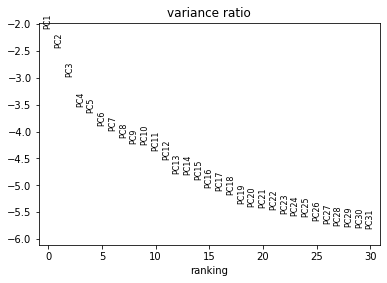

In [11]:
sc.pl.pca_variance_ratio(adata, log=True)

## Neighbouring

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


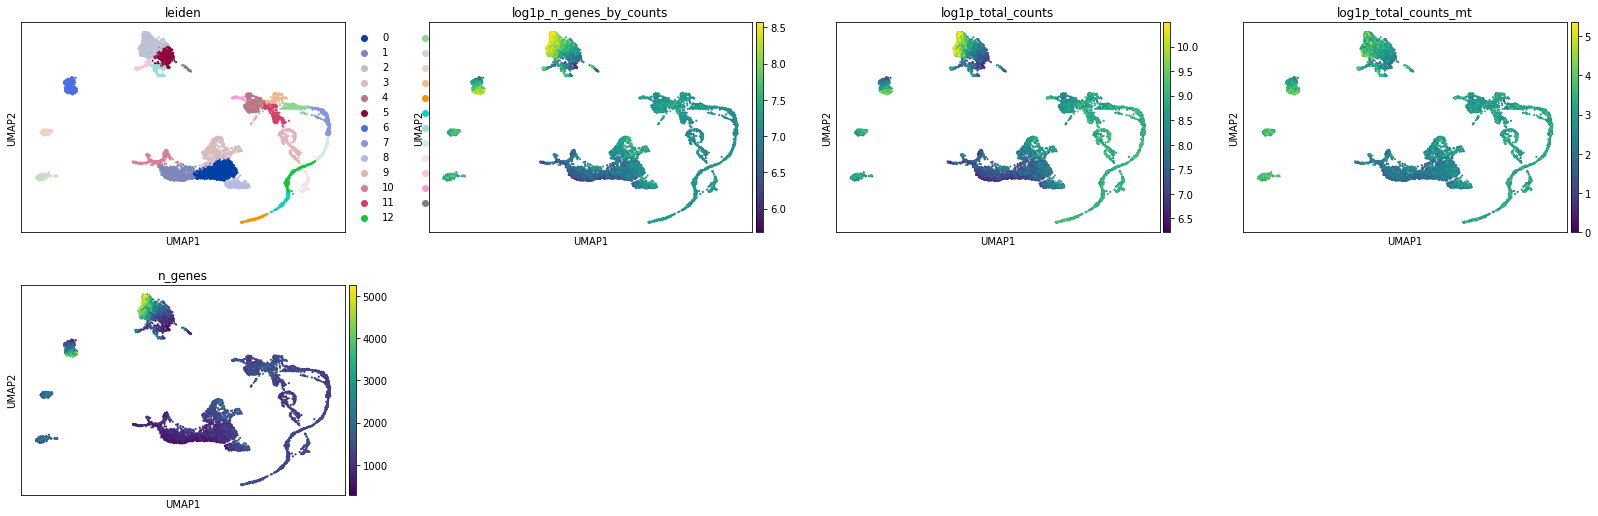

In [12]:
sc.pp.neighbors(adata)

sc.tl.umap(adata)

sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden','log1p_n_genes_by_counts','log1p_total_counts','log1p_total_counts_mt','n_genes'])

running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0_1', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0_01', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_res0_5', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden_res1', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 34 clusters and added
    'leiden_res2', the cluster labels (adata.obs, categorical) (0:00:02)


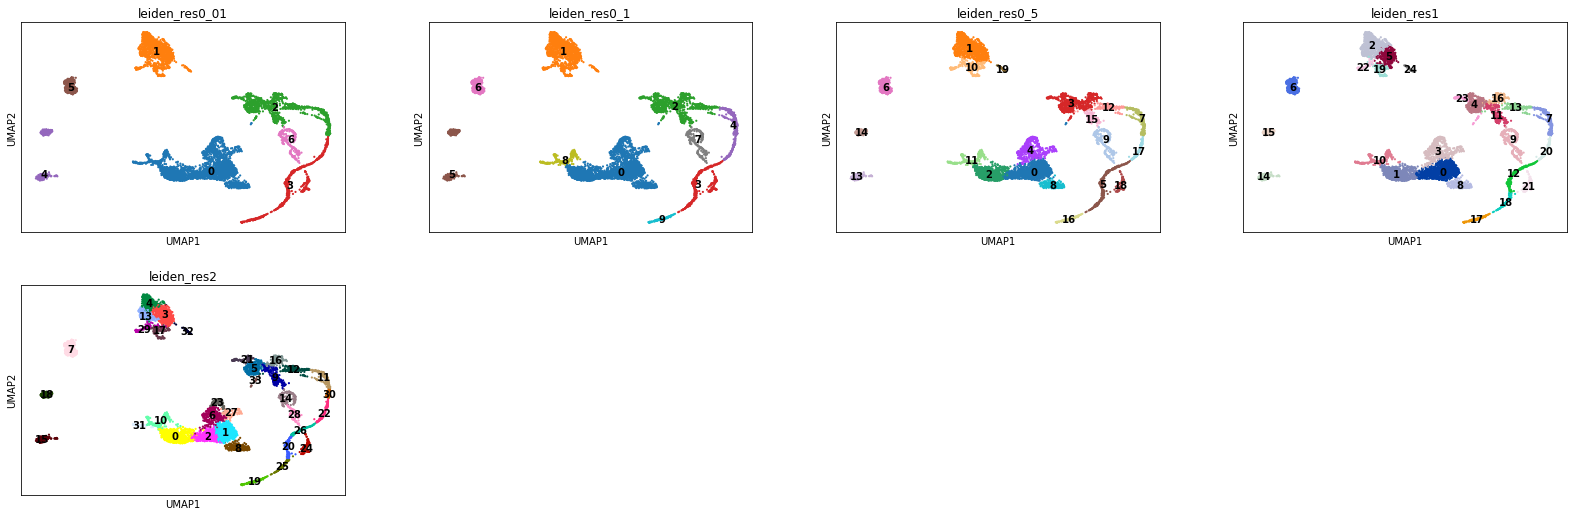

In [24]:
sc.tl.leiden(adata, key_added="leiden_res0_1", resolution=0.1)
sc.tl.leiden(adata, key_added="leiden_res0_01", resolution=0.05)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)

sc.pl.umap(adata, color=["leiden_res0_01","leiden_res0_1", "leiden_res0_5", "leiden_res1","leiden_res2"],legend_loc="on data",)

## Marker genes

In [14]:
sc.tl.rank_genes_groups(adata, "leiden_res1", method="t-test", key_added="dea_leiden_1")
# sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

ranking genes
    finished: added to `.uns['dea_leiden_1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)


In [19]:
# sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon", key_added="dea_leiden_1")
# sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

ranking genes
    finished: added to `.uns['dea_leiden_1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


KeyError: 'rank_genes_groups'

Filtering genes using: min_in_group_fraction: 0.2 min_fold_change: 1, max_out_group_fraction: 0.2


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res1']`


/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


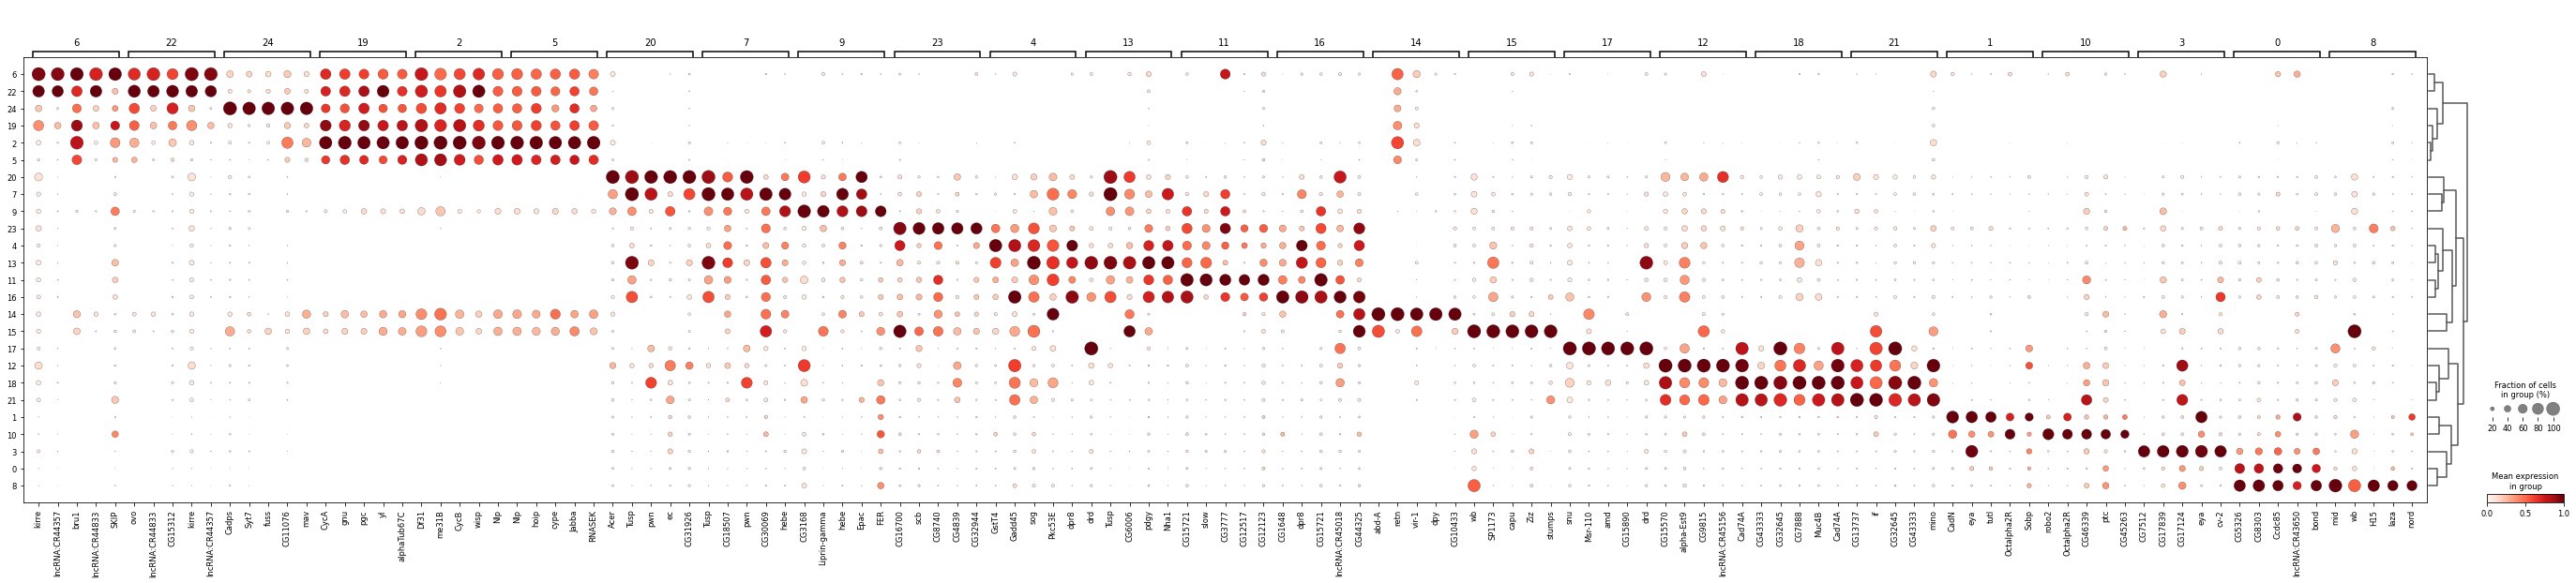

In [16]:
sc.tl.filter_rank_genes_groups(adata, key="dea_leiden_1", min_in_group_fraction=0.2, max_out_group_fraction=0.2, key_added="dea_leiden_1_filtered")

sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res1", standard_scale="var", n_genes=5, key="dea_leiden_1_filtered")

In [18]:
# result = adata.uns["rank_genes_groups"]
# groups = result["names"].dtype.names
# pd.DataFrame(
#     {
#         group + "_" + key[:1]: result[key][group]
#         for group in groups
#         for key in ["names", "pvals"]
#     }
# ).head(5)

KeyError: 'rank_genes_groups'

In [20]:
adata.uns["dea_leiden_1_filtered"]["names"]

rec.array([(nan, nan, nan, nan, nan, nan, 'kirre', 'Tusp', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           (nan, nan, 'Df31', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'abd-A', nan, nan, nan, 'CG43333', nan, nan, nan, nan, nan, nan),
           (nan, nan, 'me31B', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           ...,
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
           (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O'), ('8', 'O'), ('9', 

Marker genes for cluster 1


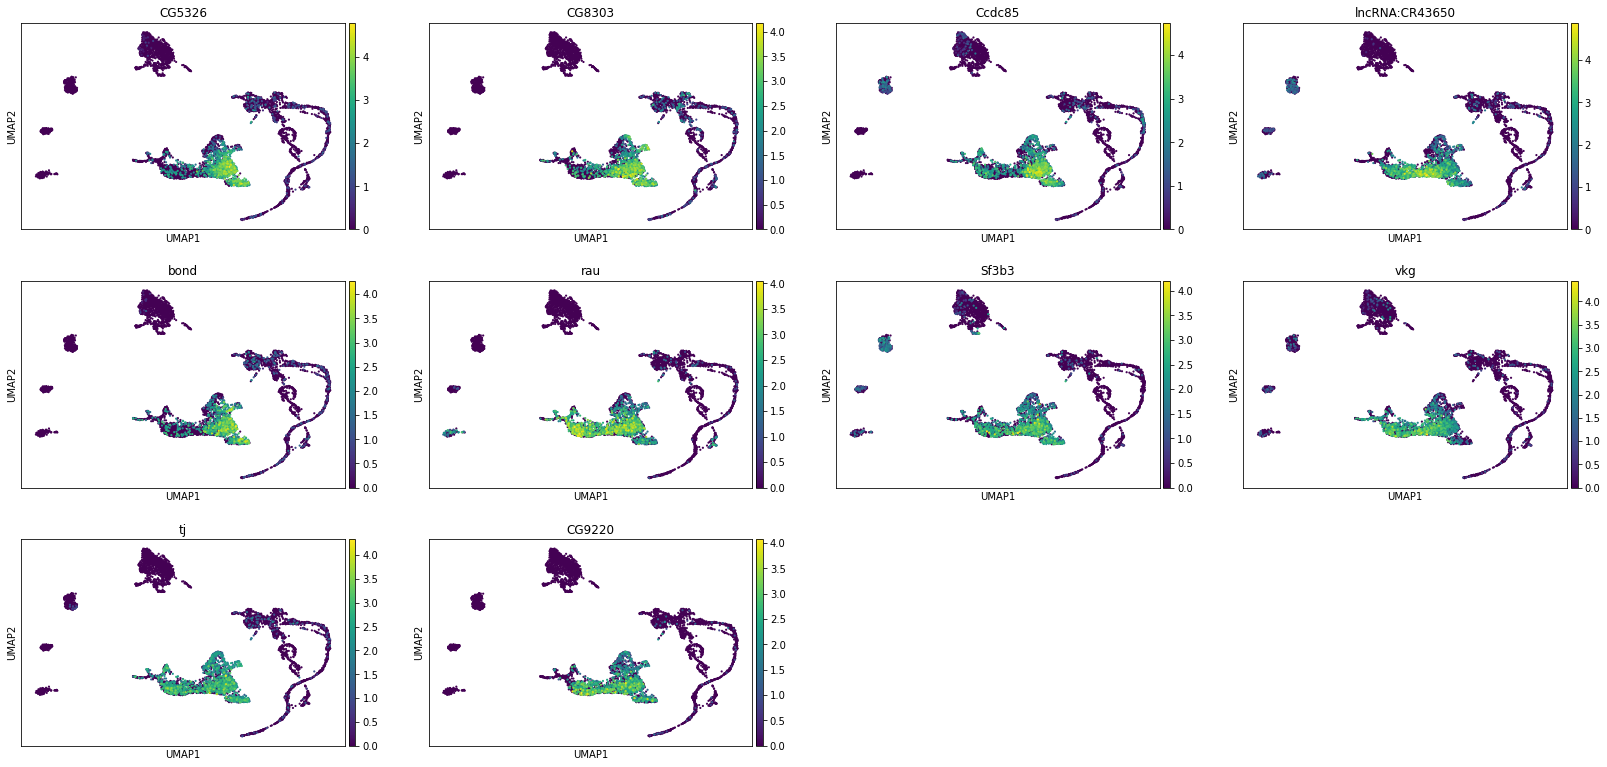

Marker genes for cluster 2


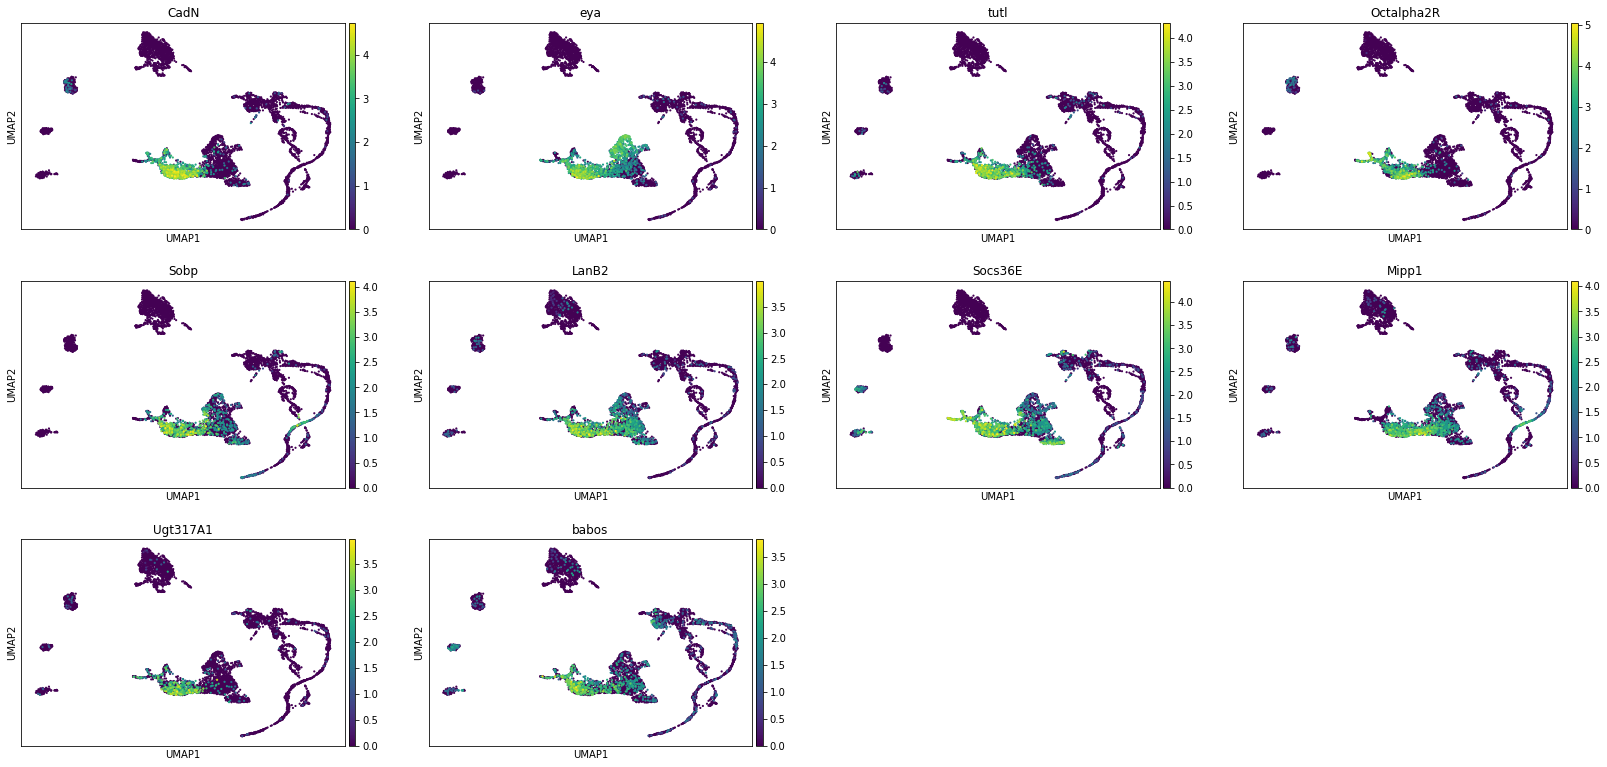

Marker genes for cluster 3


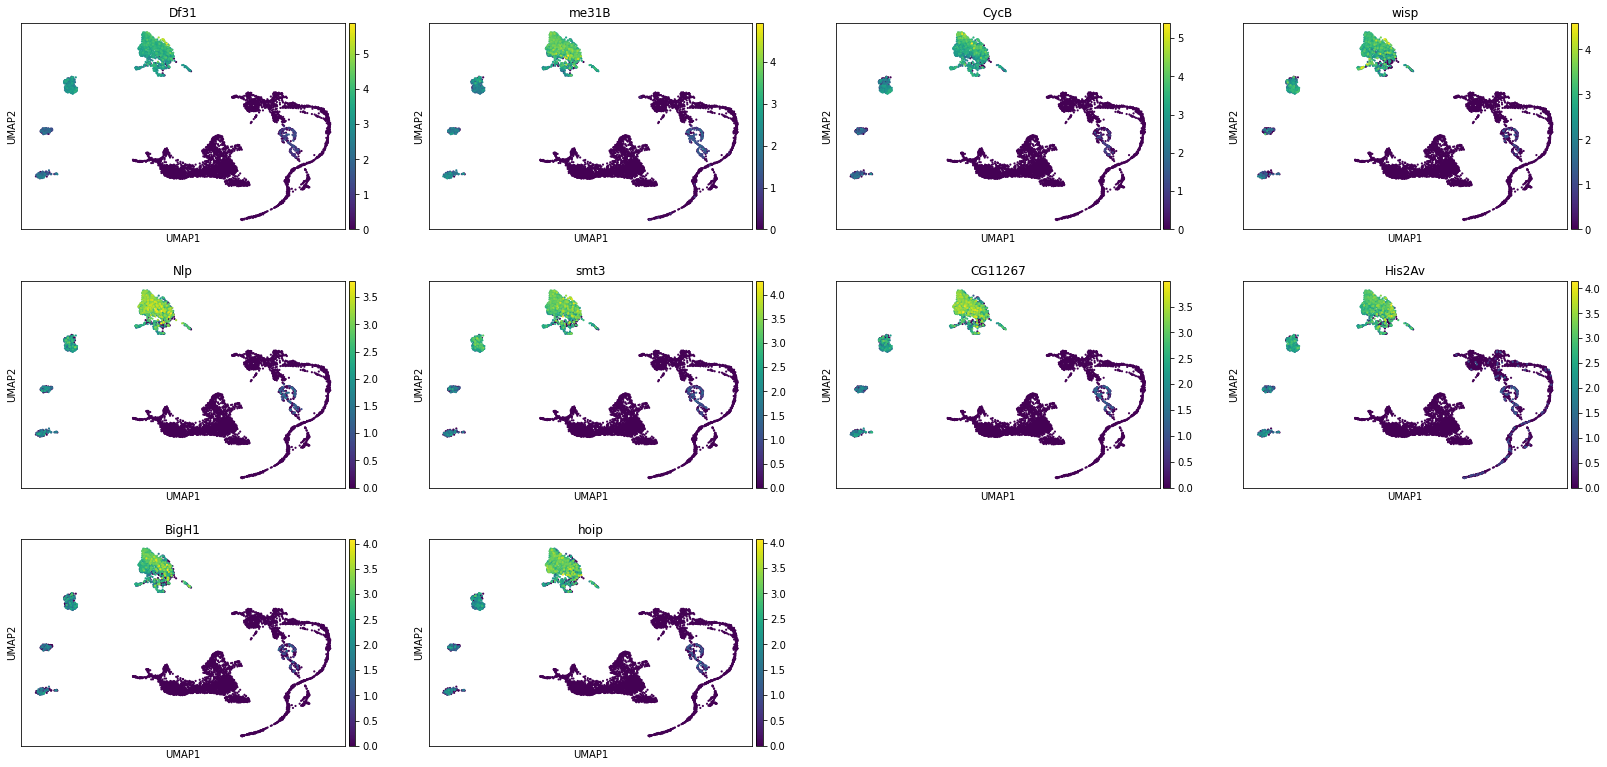

Marker genes for cluster 4


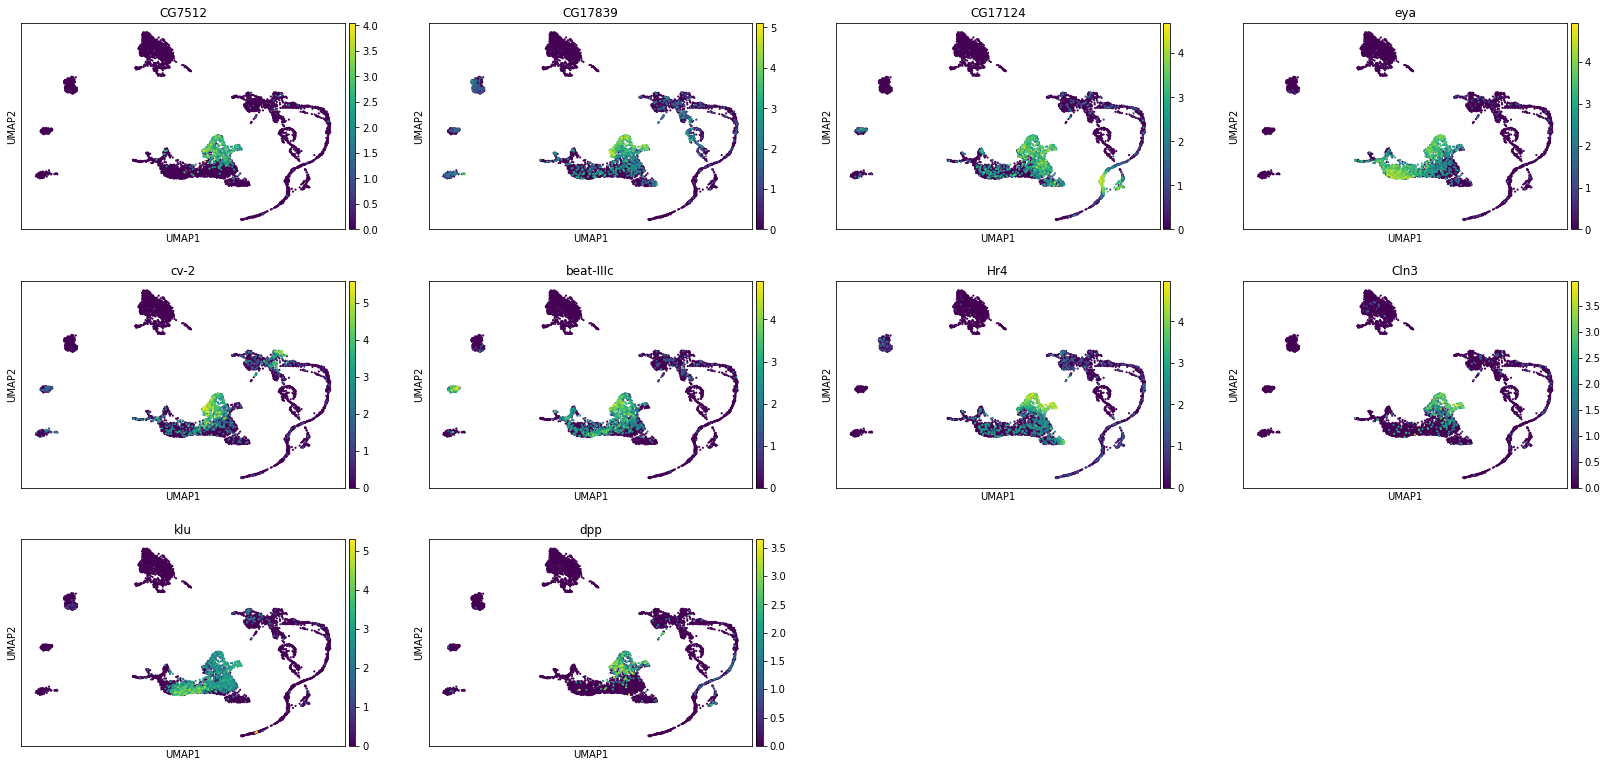

Marker genes for cluster 5


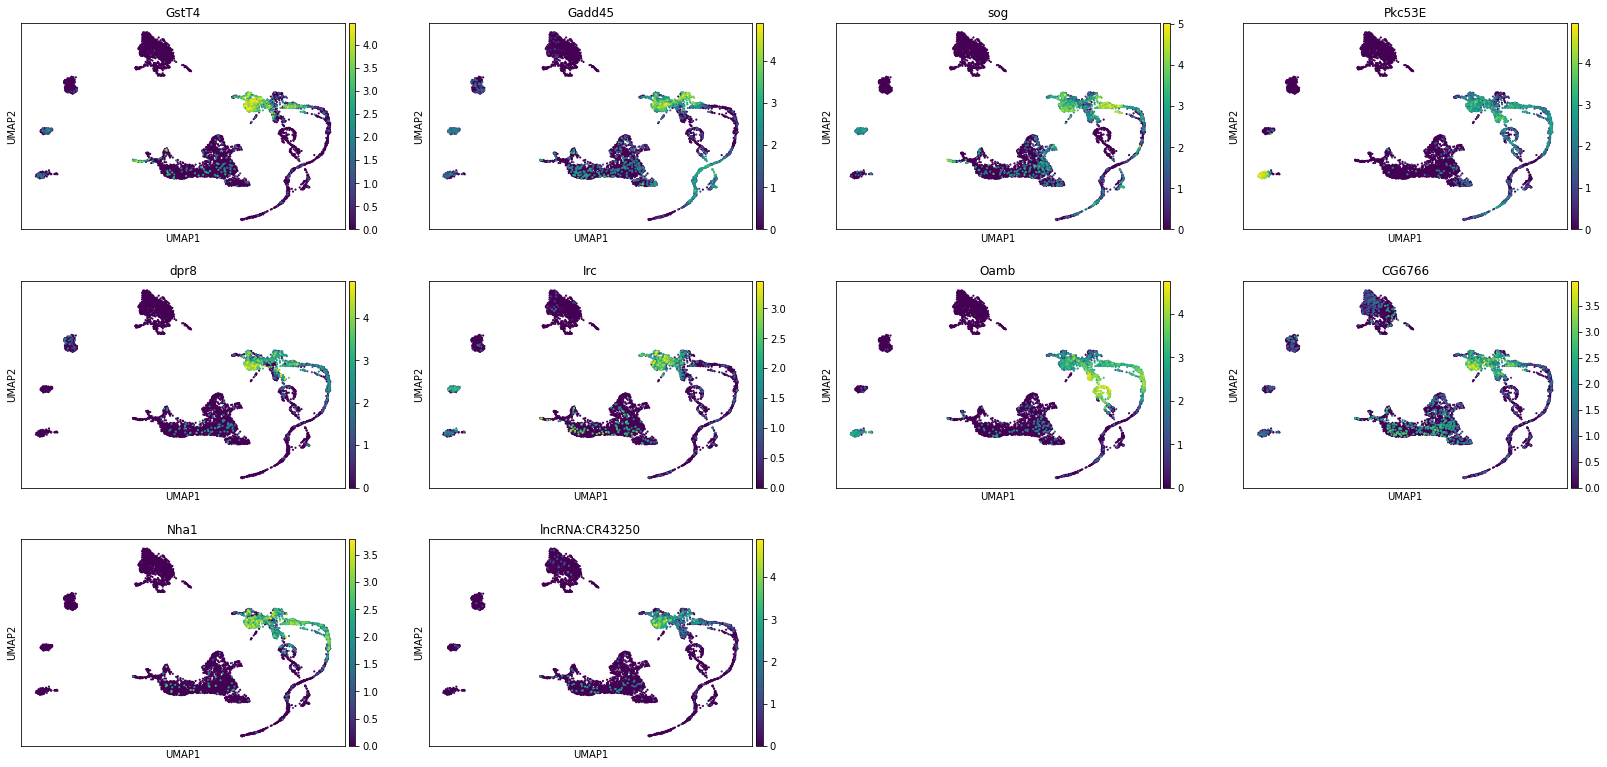

Marker genes for cluster 6


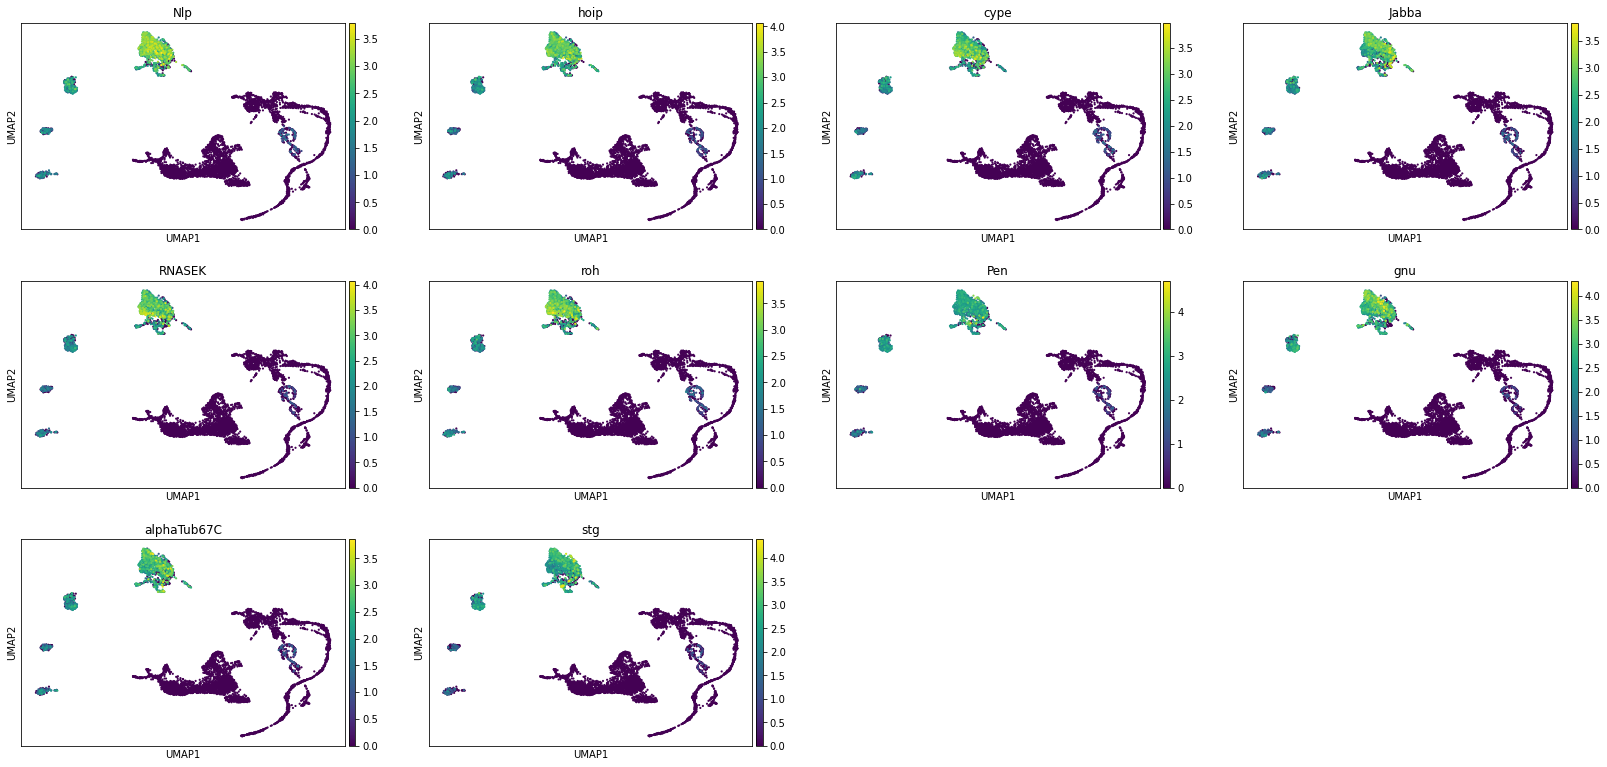

Marker genes for cluster 7


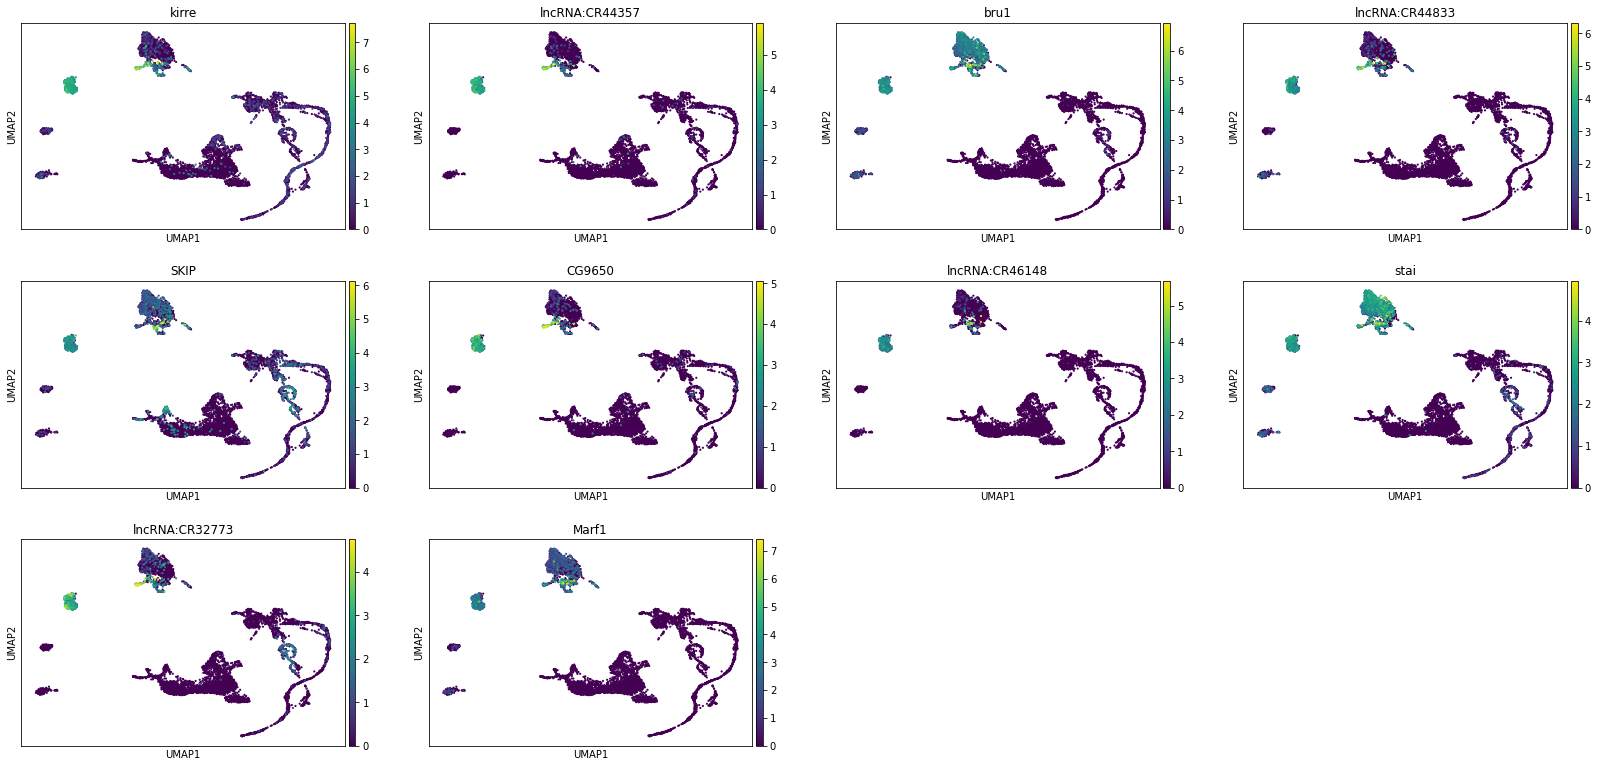

Marker genes for cluster 8


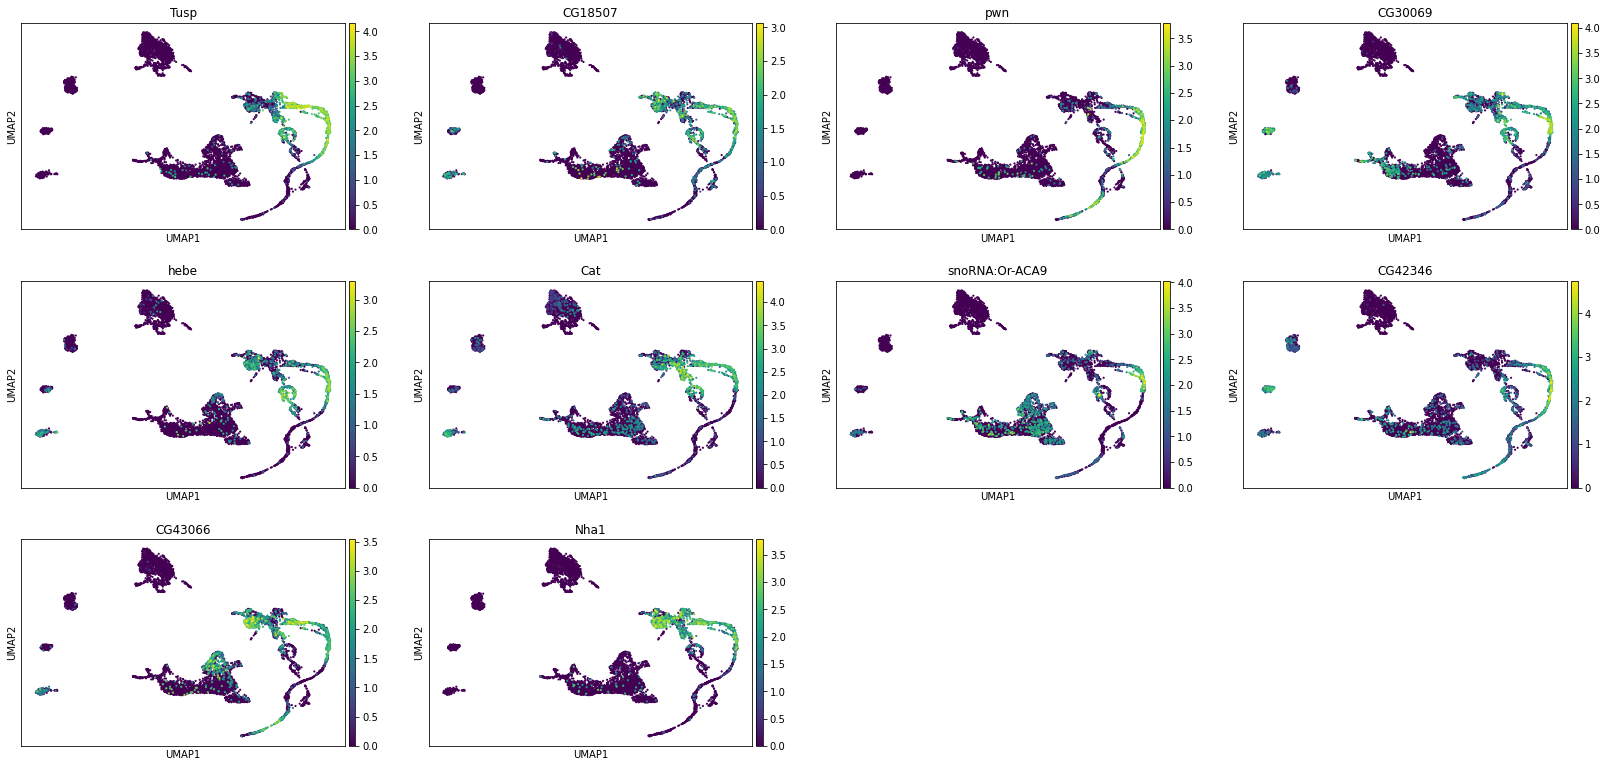

Marker genes for cluster 9


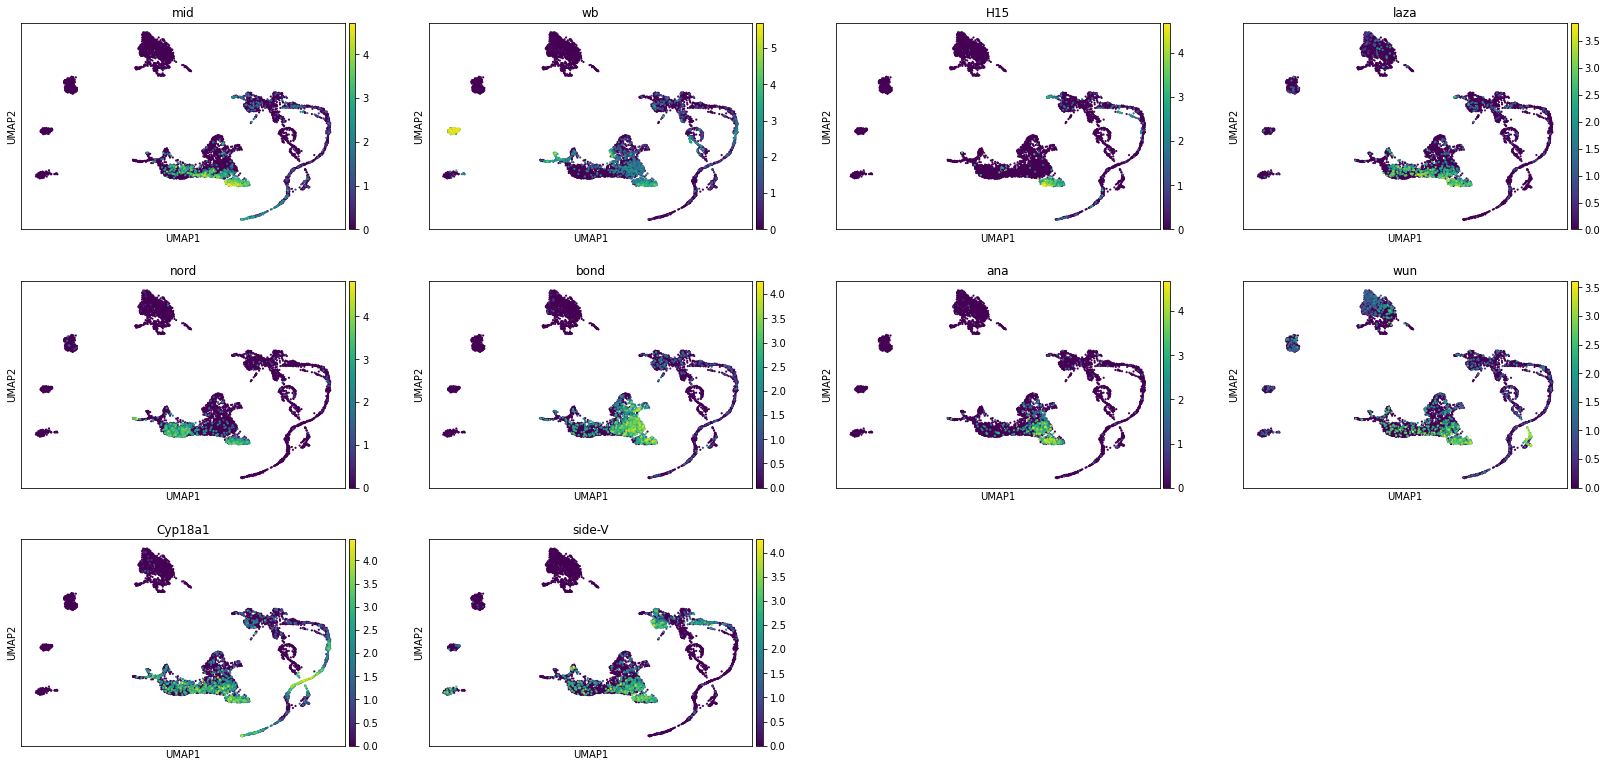

Marker genes for cluster 10


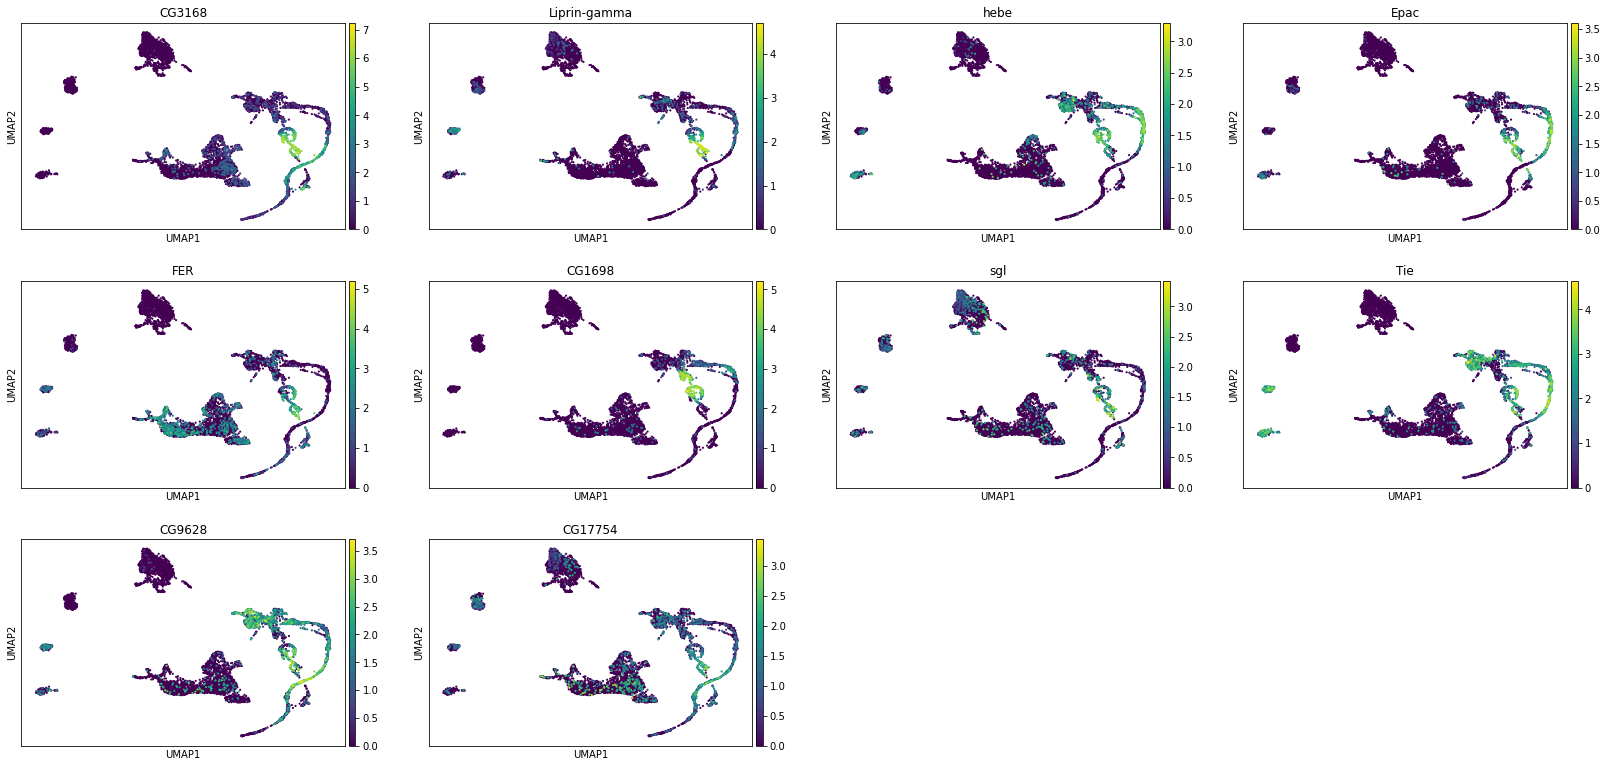

Marker genes for cluster 11


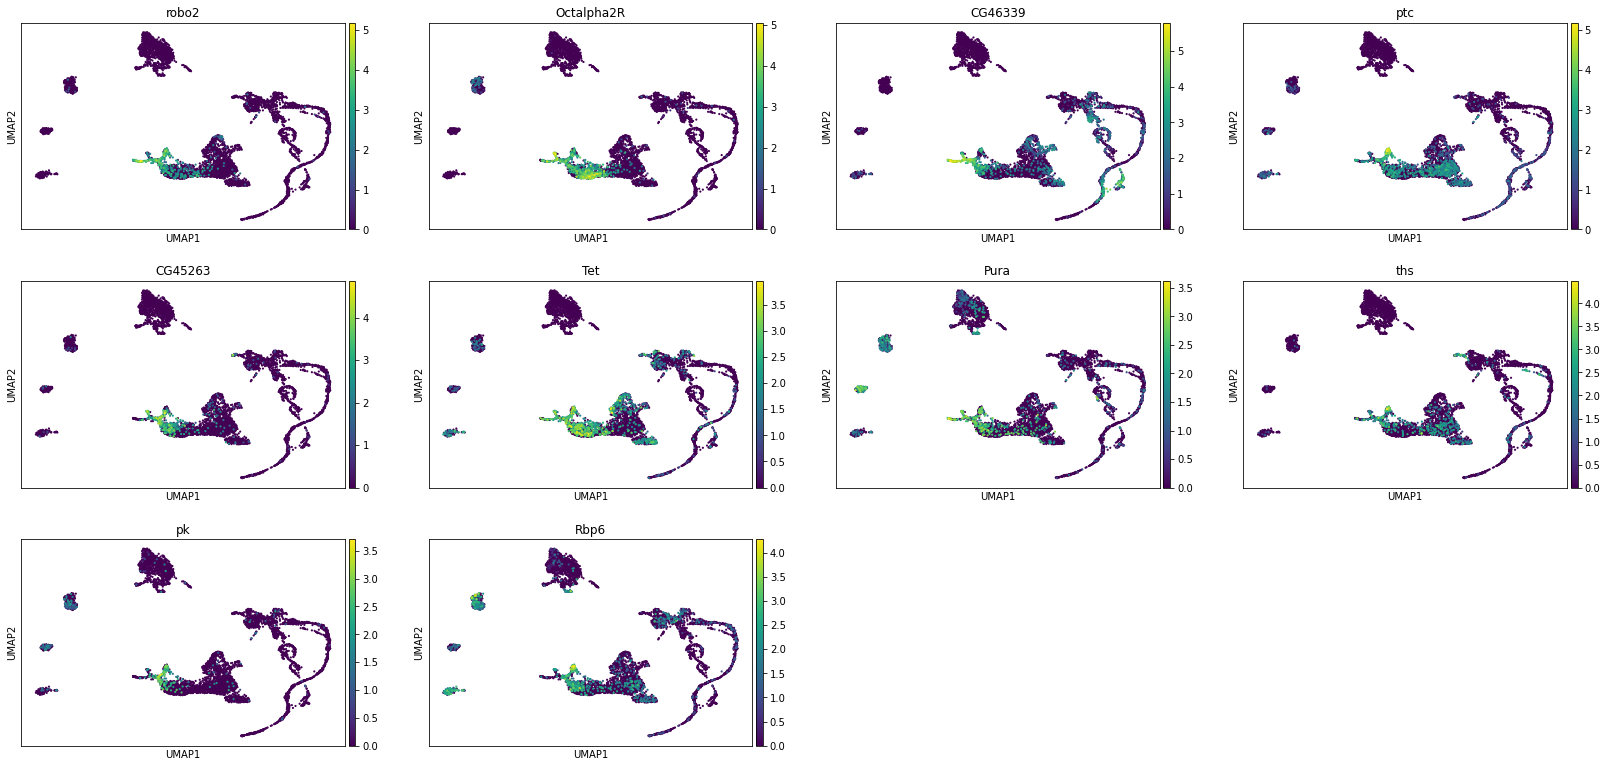

Marker genes for cluster 12


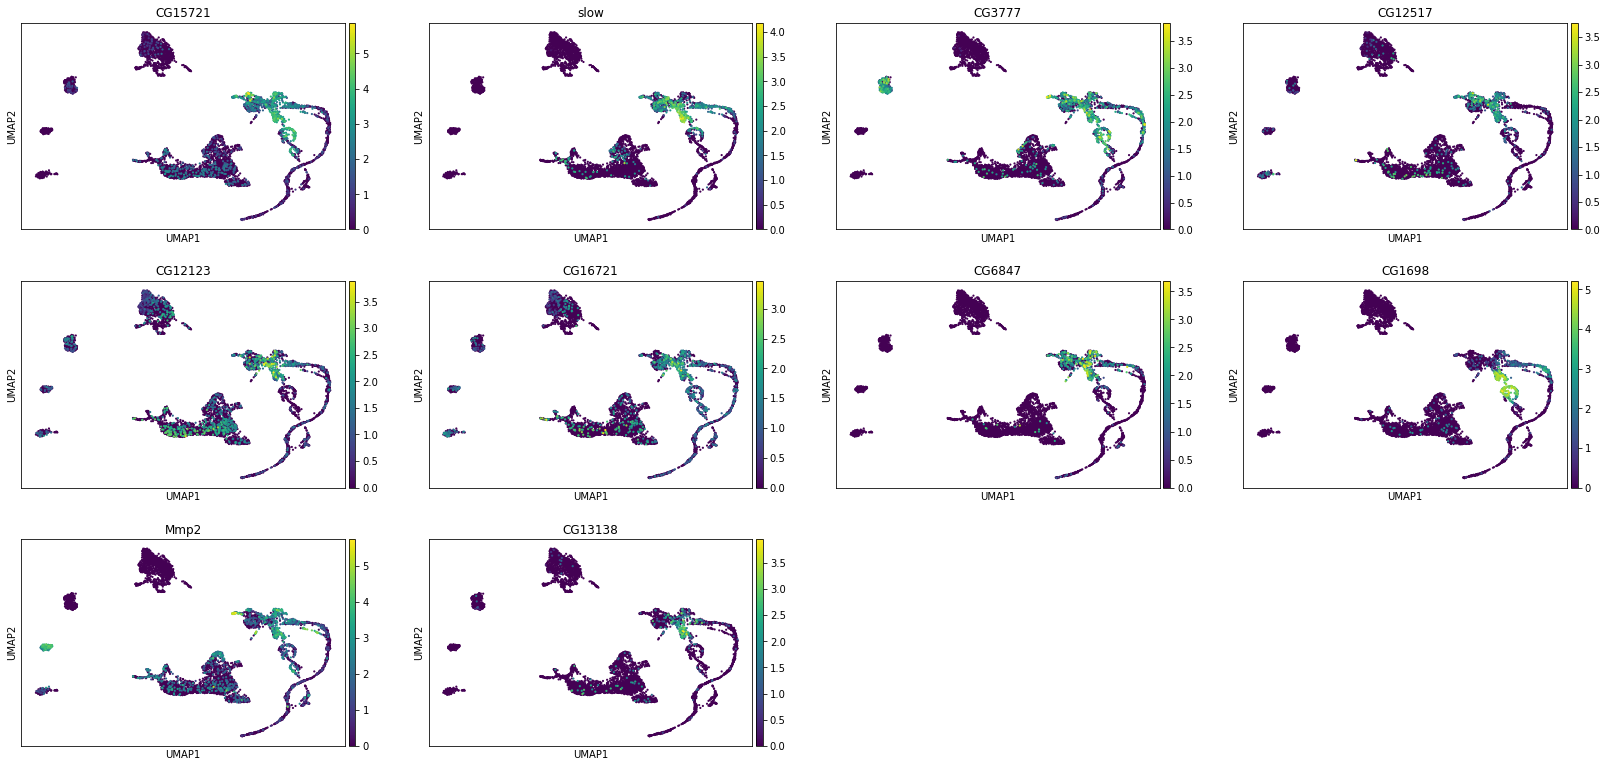

Marker genes for cluster 13


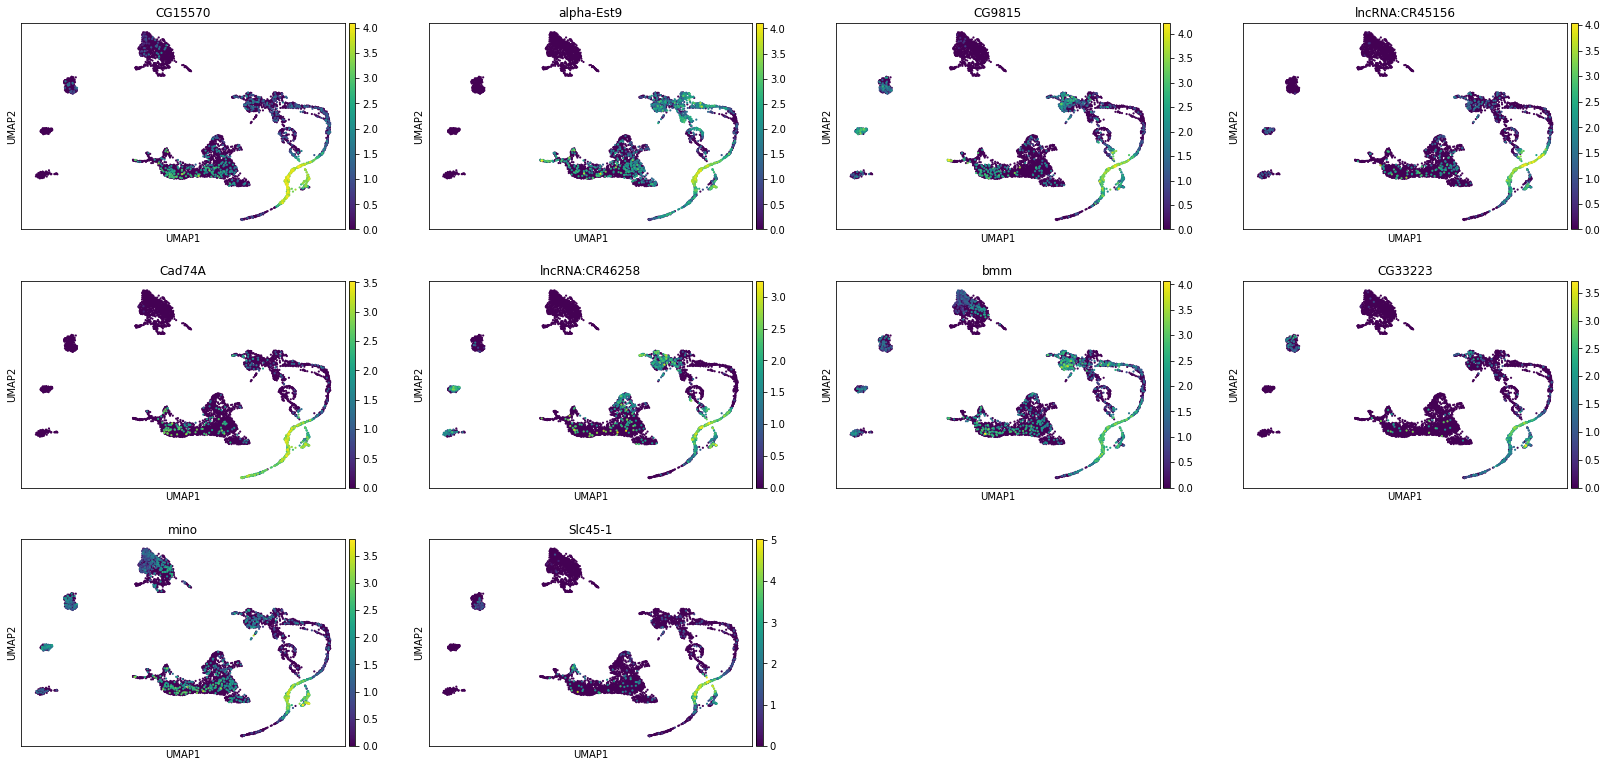

Marker genes for cluster 14


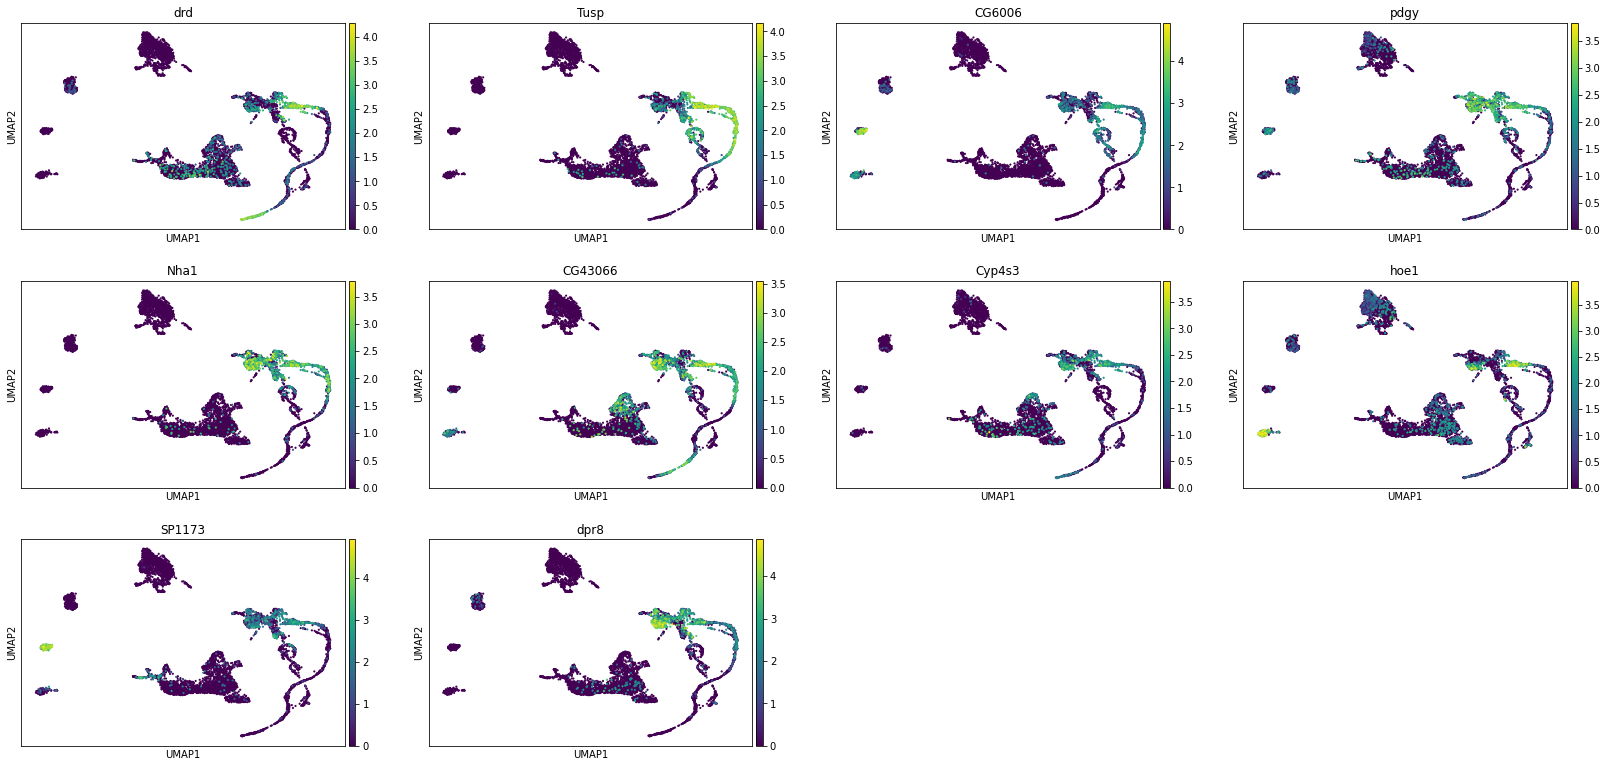

Marker genes for cluster 15


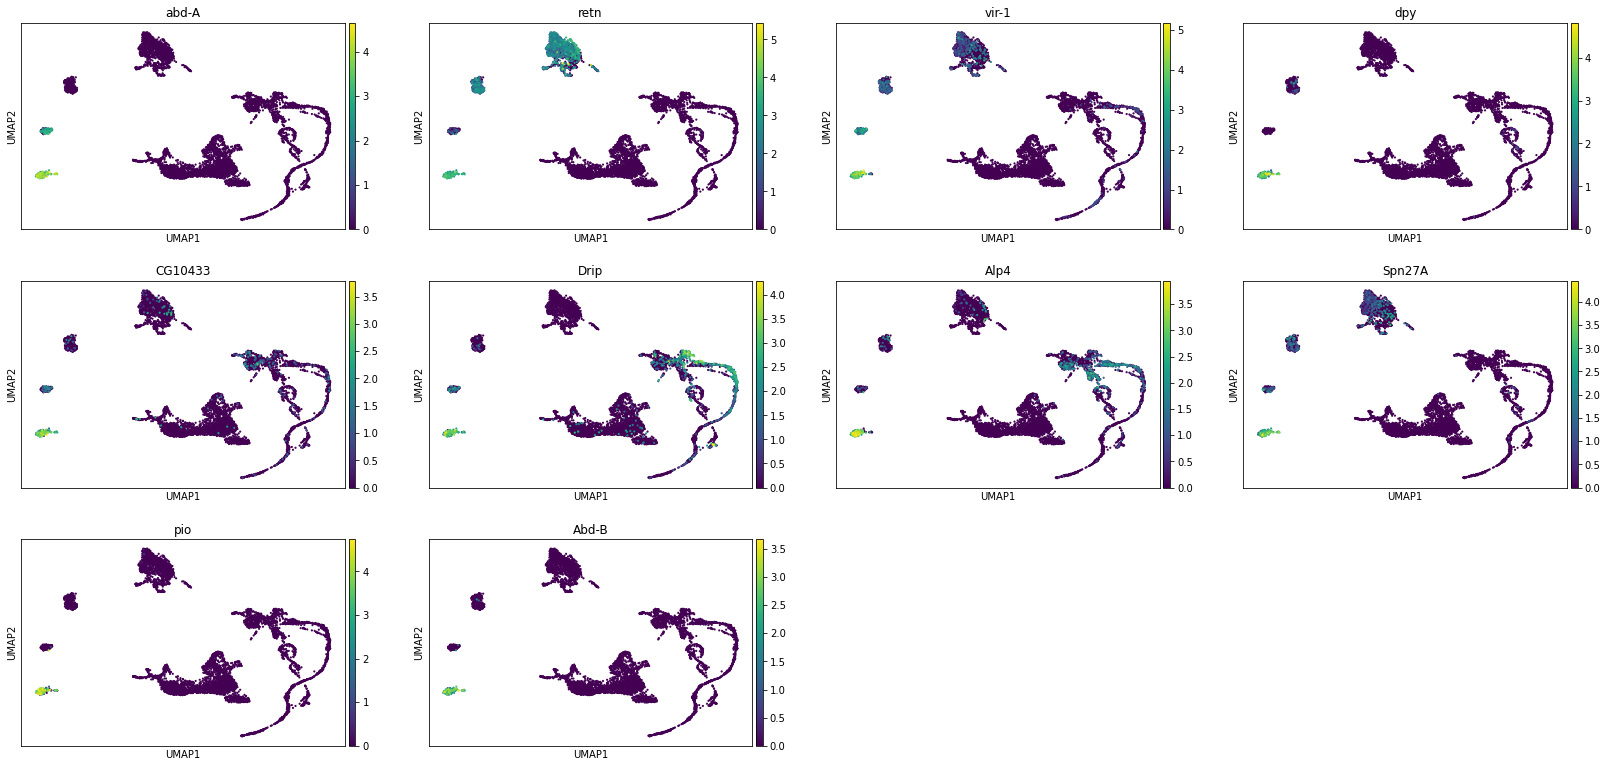

Marker genes for cluster 16


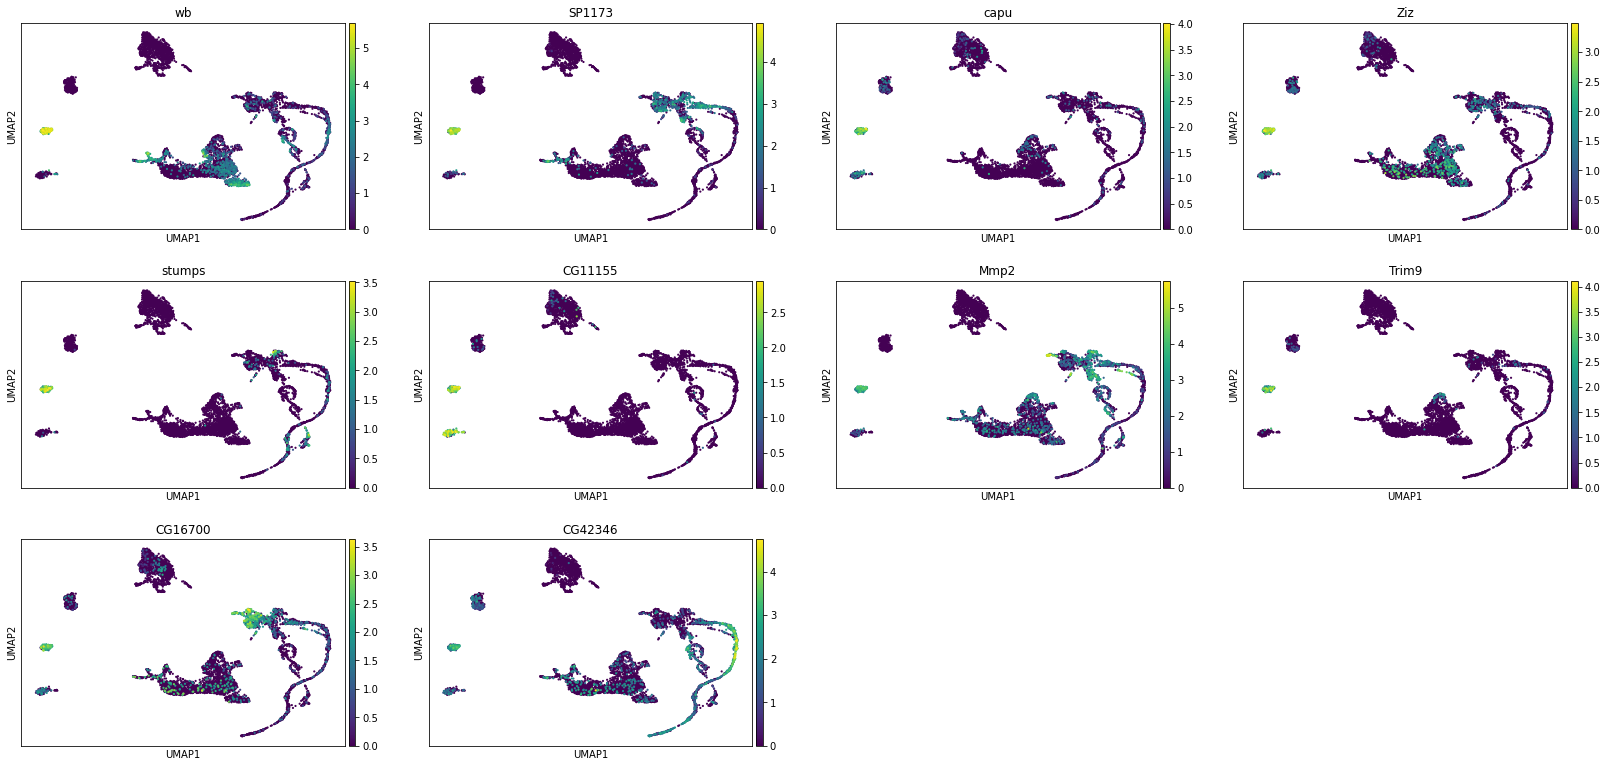

Marker genes for cluster 17


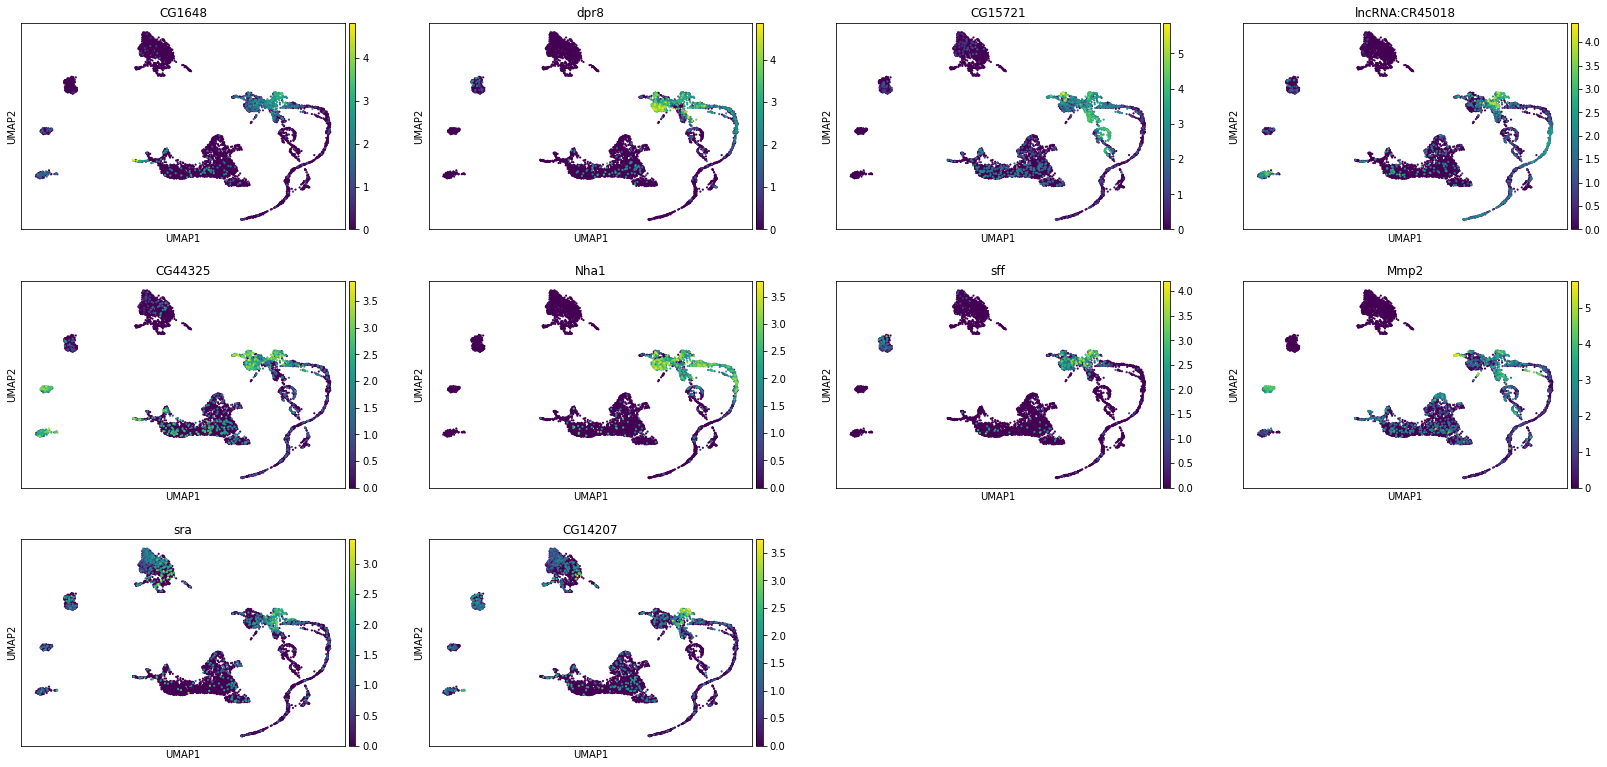

Marker genes for cluster 18


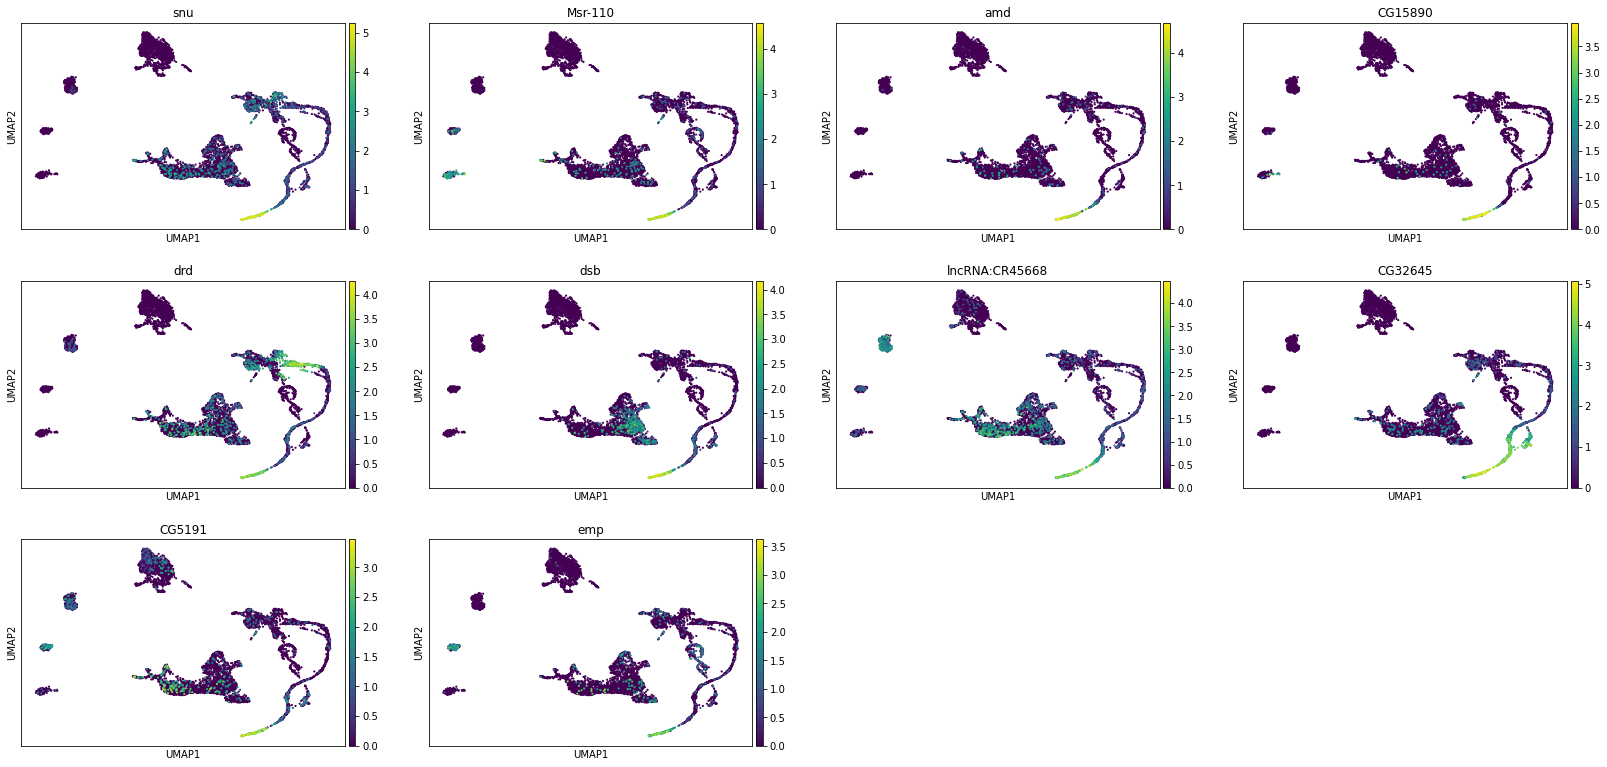

Marker genes for cluster 19


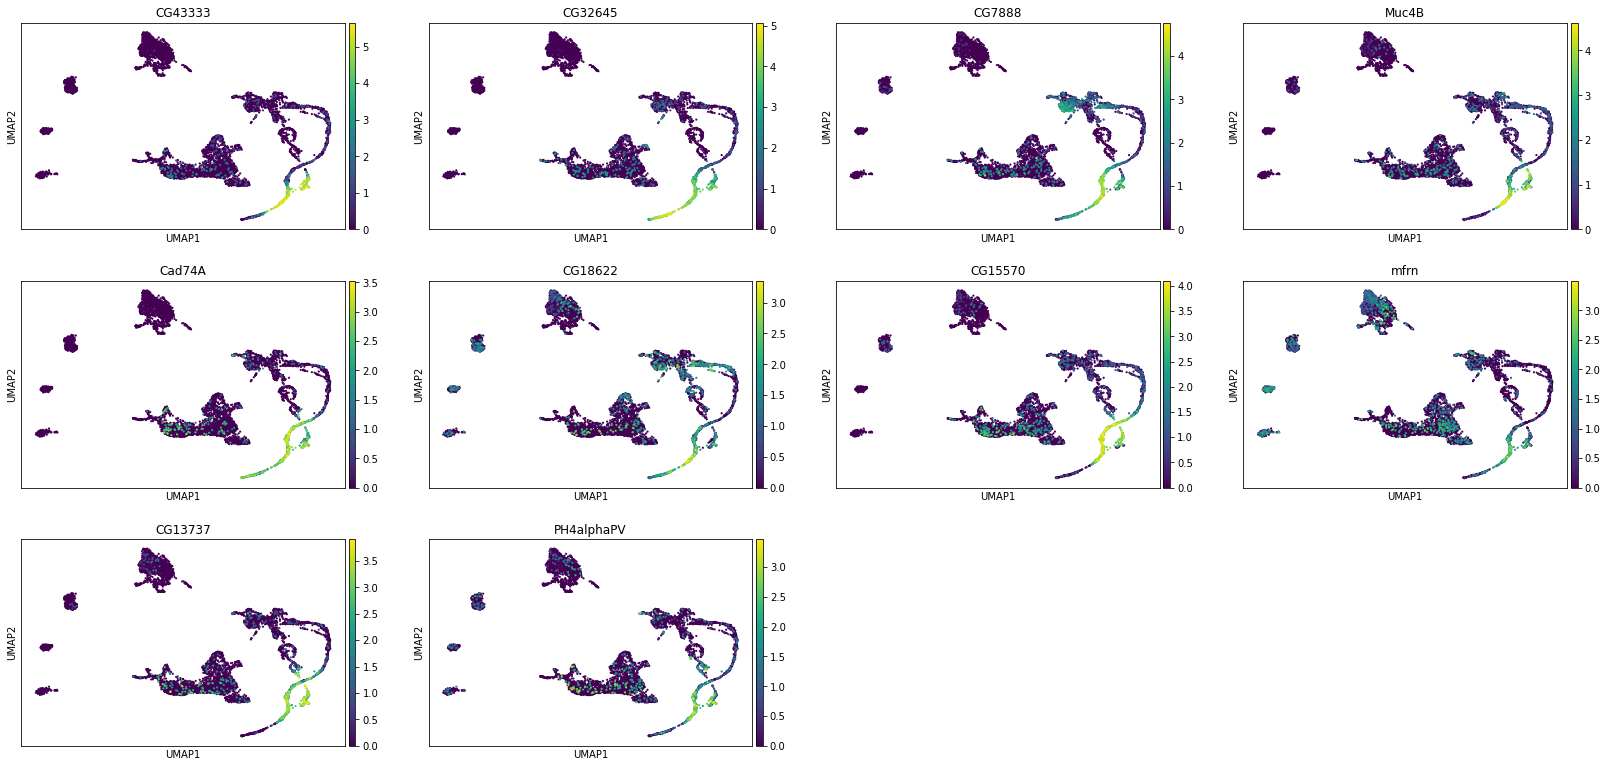

Marker genes for cluster 20


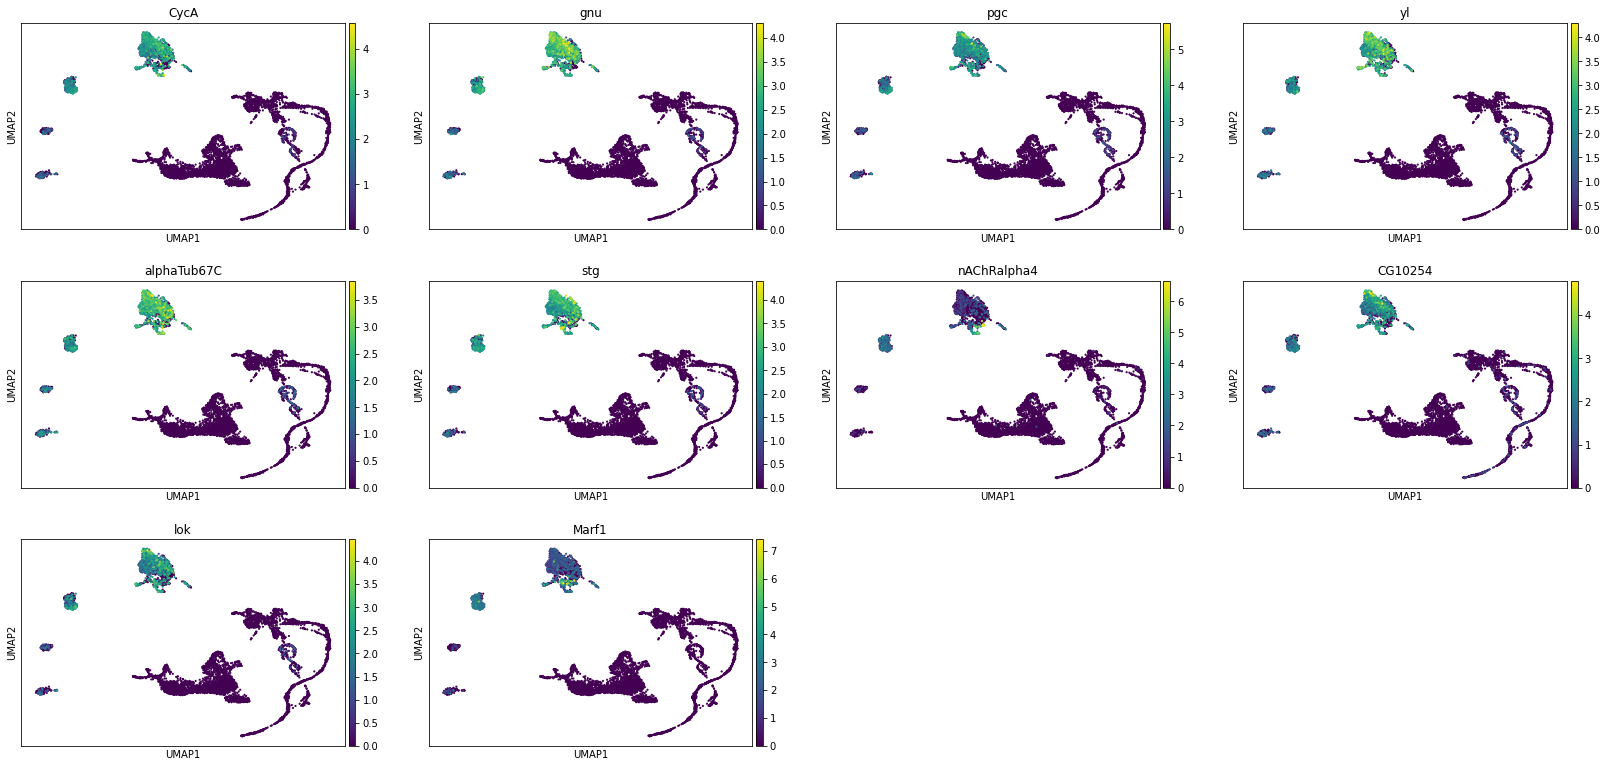

Marker genes for cluster 21


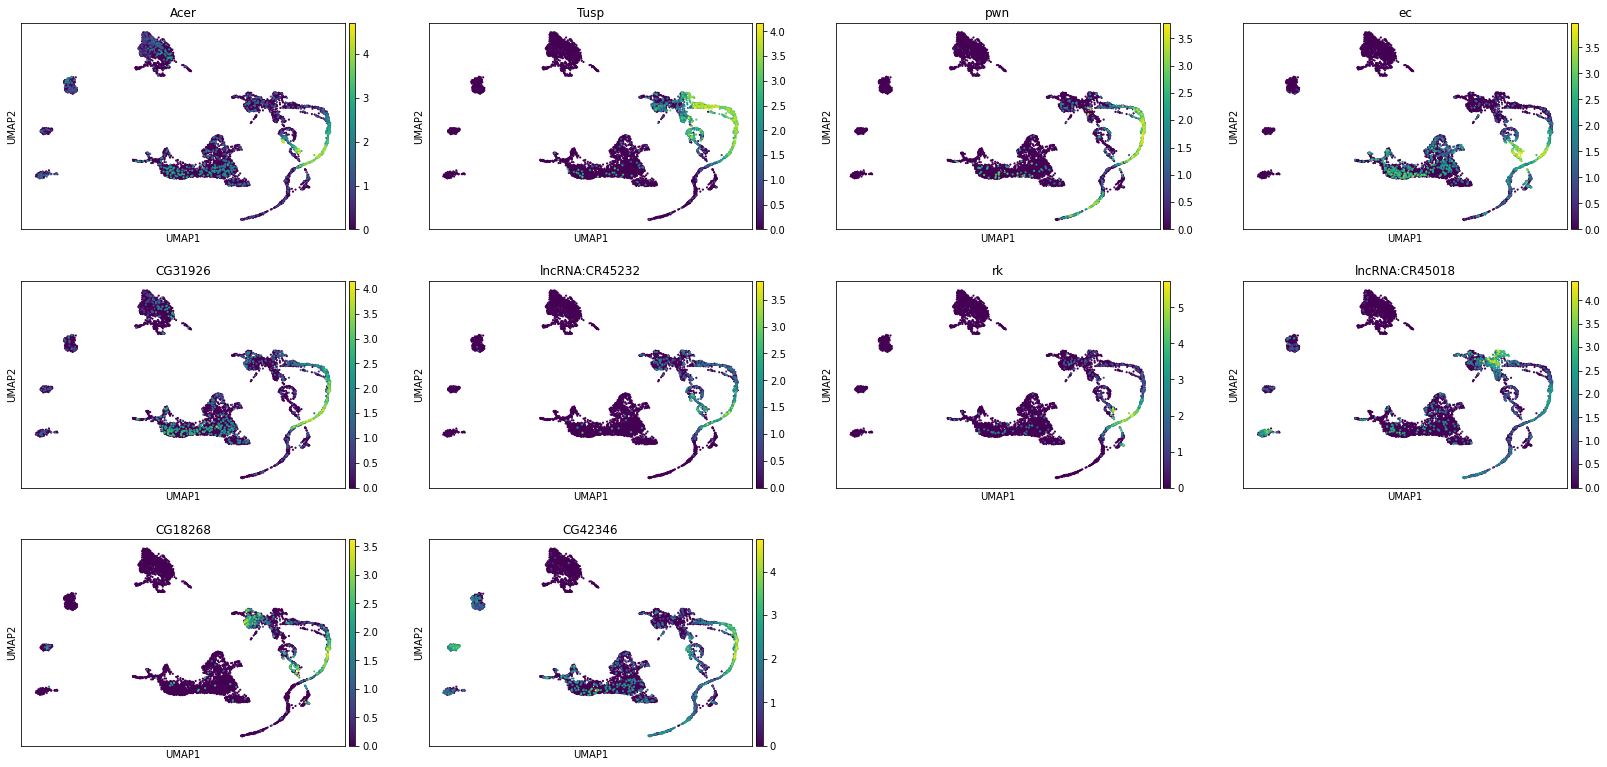

Marker genes for cluster 22


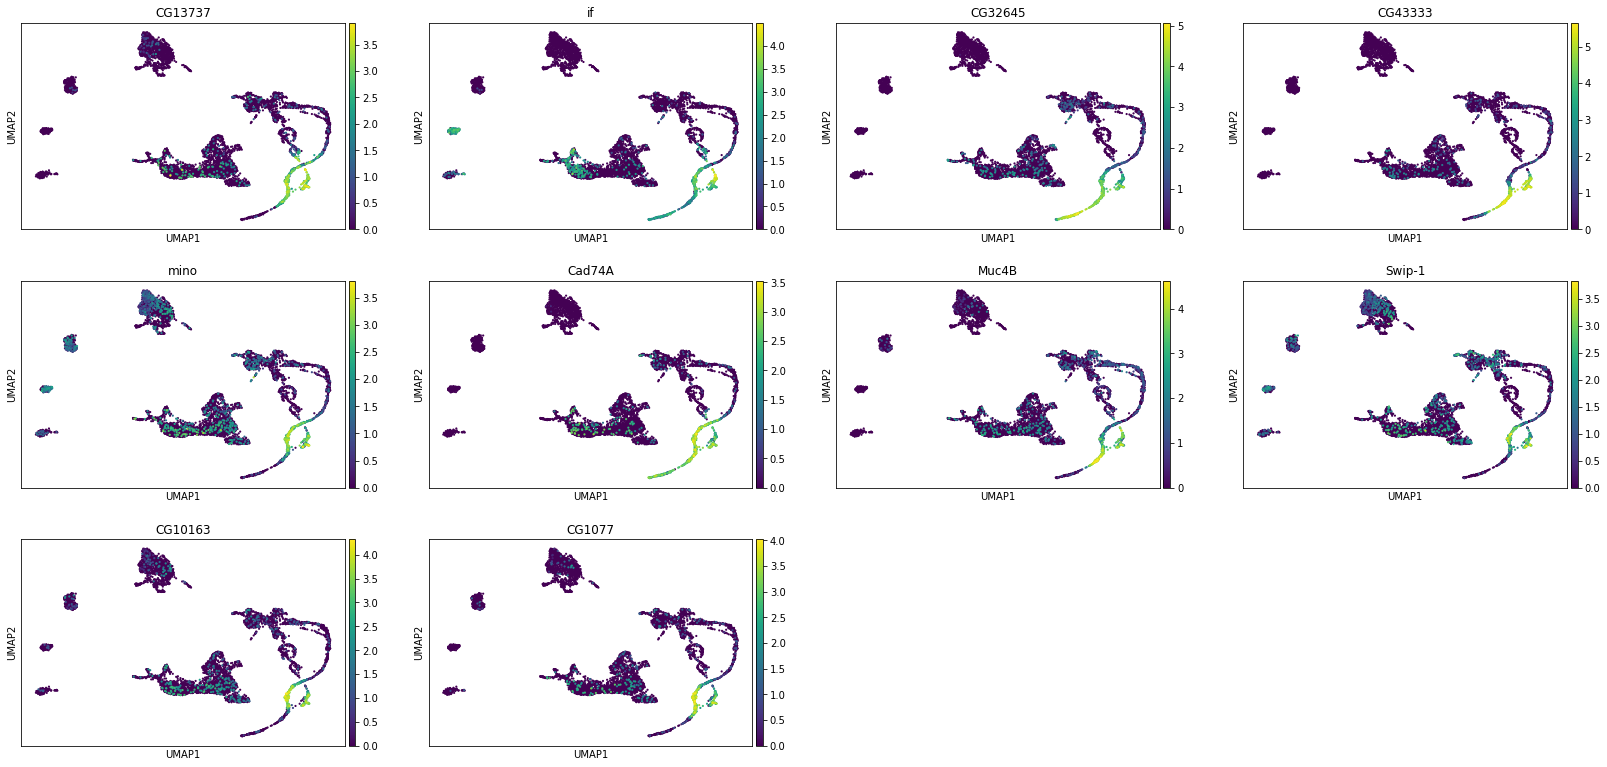

Marker genes for cluster 23


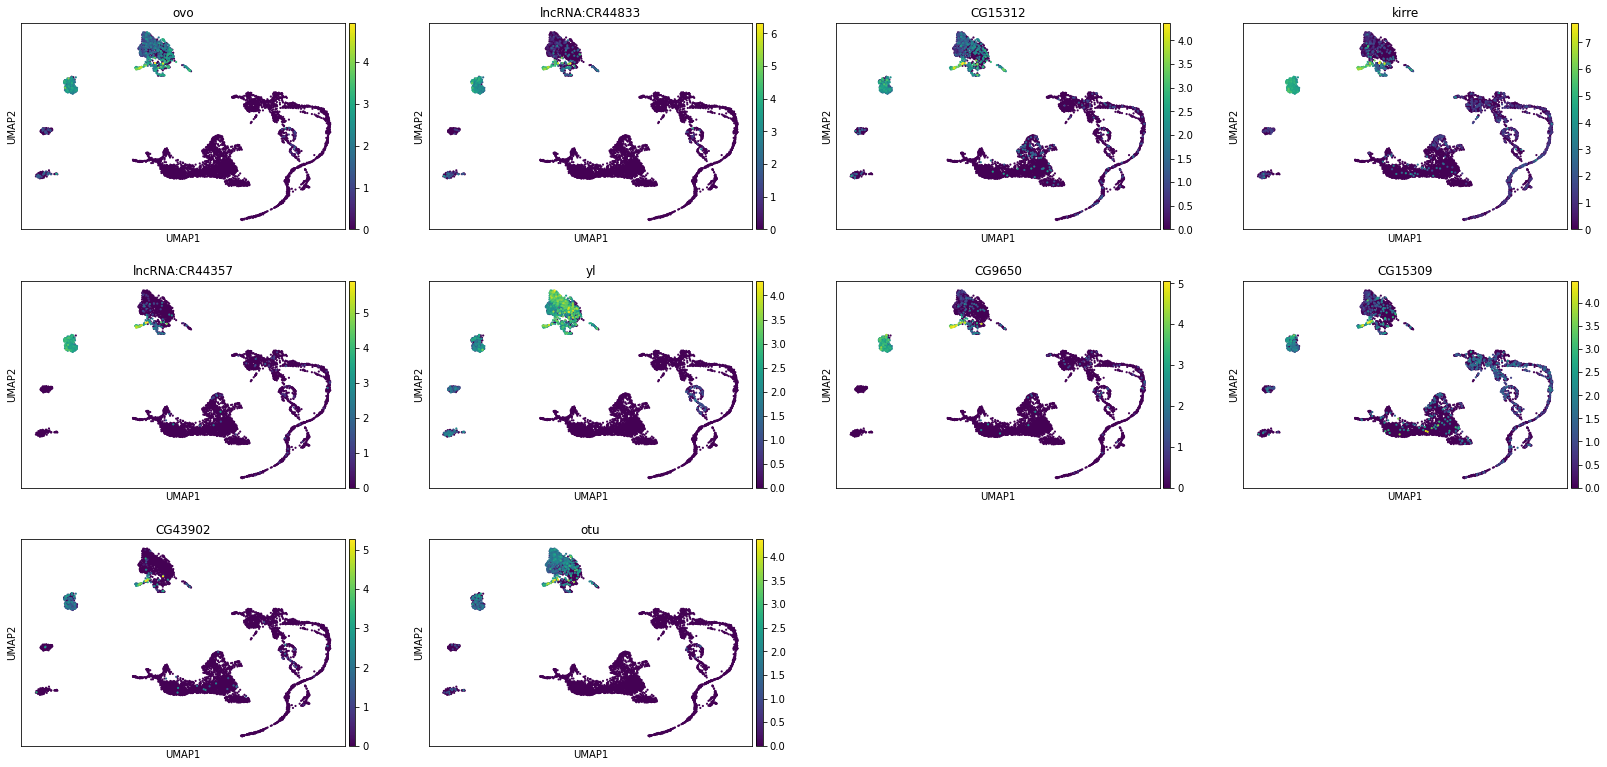

Marker genes for cluster 24


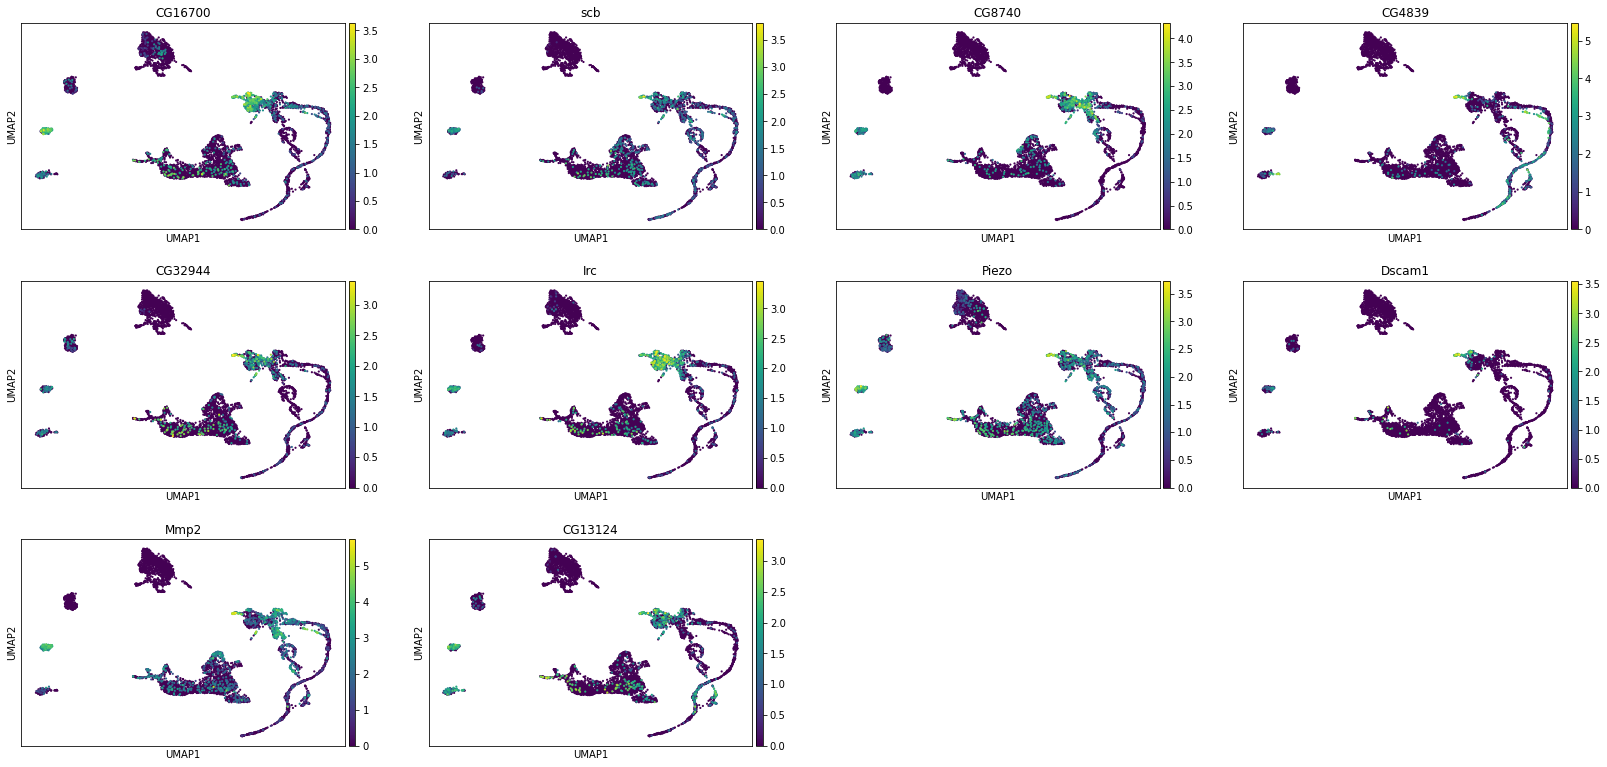

Marker genes for cluster 25


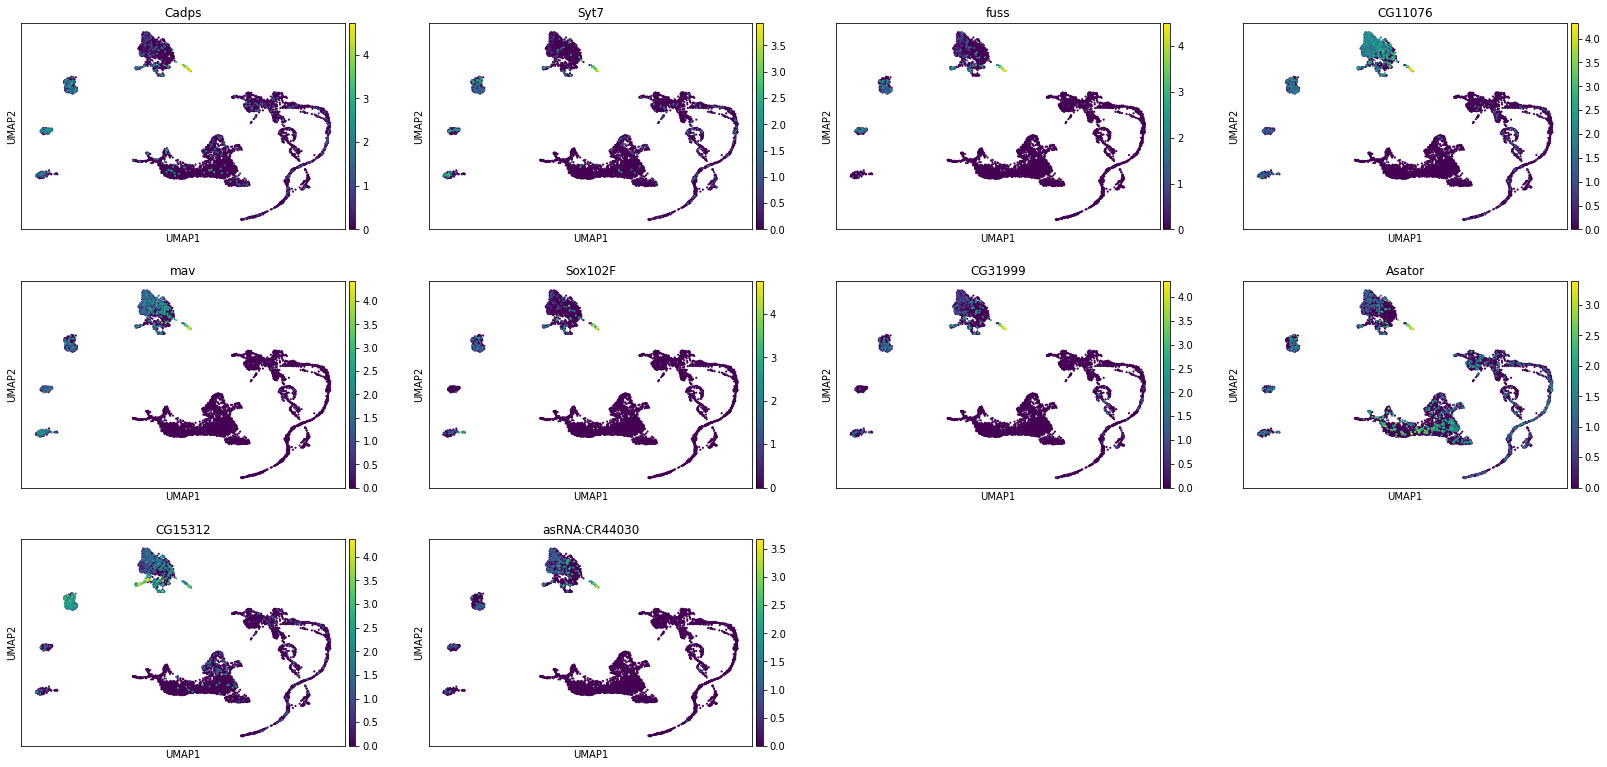

In [21]:
markers = pd.DataFrame(data=adata.uns["dea_leiden_1_filtered"]["names"])

i= 0
for col in markers.columns :
    i = i+1
    markers_genes = markers[col].dropna().tolist()[:10]
    print('Marker genes for cluster {}'.format(i))
    sc.pl.umap(adata, color=[j for j in markers_genes ])

1 2 4 -> main body follicle cells
3 -> strech follicle
8 -> posterior terminal follicle
11 -> follicle stem cell
5 7 12 13 14 15 18 19 -> chorilogenic follicle cells (5 13 15 18 + corpus luteum : important car tjrs séparés meme en leiden 0.05)
16 17 -> oviduct
20 9 -> dorsal duct
0 6 10 22 -> germline (6 a part)
21 -> unannoted

4 in dentifiable categroy, with follicle cells a super category incluning 5 sub category 